# Table of contents
1. [Figure 4A and 4C. Cox models for PFS in IO+VEGF arms of IMM151 and JAV101 (IFNG signatures)](#1)
2. [Figure 4B and 4D. Survival curves for PFS in IO+VEGF vs VEGF arms of IMM151 and JAV101](#2)
3. [Figure 4E. Scatter plots showing hazard ratios and odds ratios for all myeloid signatures in models for PFS and CB/NCB in IMM151 and JAV101](#3)

In [1]:
library(harmony)
library(hacksig)
library(car)
library(corrplot)
library(ComplexHeatmap)
library(rstatix)
library(stringr)
library(Seurat)
library(useful)
library(dplyr)
library(ggpubr)
library(ggrepel)
library(glue)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(reshape2)
library(lmerTest)
library(Scillus)
library(cowplot)
library(viridis)
library(hrbrthemes)
library(ggridges)
library(pheatmap)
library(ggplot2)
library(magrittr)
library(broom)
library(yarrr)

library(survival)
library(survminer)
library(tidyverse)
library(forestmodel)
library(scales)
library(pROC)
library(car)


set.seed(1234)

options(repr.plot.width=12, repr.plot.height=9)

Loading required package: Rcpp

Loading required package: carData

corrplot 0.92 loaded

Loading required package: grid

ComplexHeatmap version 2.8.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


Attaching SeuratObject

Attaching sp

Loading required package: ggplot2


Attaching package: 'dplyr'


The following object is masked from 'package:car

In [2]:
ISG_sigs = readRDS("../Signatures/Final_Manuscript_Signatures_CTS_ISGs.RDS")
ISG_sigs$manuscript_myeloid_combined
ISG_sigs$manuscript_tumor_combined
ISG_sigs$manuscript_t_nk_combined

[1] "IFI30"    "LPAR6"    "FCGR1A"   "MYD88"    "VSIG4"    "LILRB1"  
 [7] "IL10"     "SECTM1"   "MX2"      "CXCL10"   "CD86"     "GCH1"    
[13] "SIGLEC10" "FPR1"     "JAK2"     "CXCL9"    "TNFAIP2"  "PTGS2"   
[19] "IL15"     "LAMP3"    "NFKB1"

[1] "C1R"     "PFKP"    "TNFAIP6" "C1S"     "CFB"     "SSPN"

[1] "NLRC5" "OASL"  "IL2RB" "XCL1"  "GZMA"  "STAT4" "CCL5"  "SOCS1"

In [3]:
ISG_sigs$Krishna_CD8A_Tissue_resident

[1] "AKNA"      "ARAP2"     "ARHGAP9"   "CCL3"      "CCL4"      "CD8A"     
 [7] "CNOT6L"    "CRIP1"     "CRTAM"     "CXCR6"     "GPR171"    "GZMK"     
[13] "IDS"       "IFNG"      "ITK"       "KCNA3"     "LDLRAD4"   "LINC-PINT"
[19] "MTRNR2L12" "NCF1"      "NKG7"      "OXNAD1"    "PARP8"     "PIM2"     
[25] "PYHIN1"    "RNU12"     "SAMSN1"    "SH2D1A"    "SLAMF1"    "TBC1D10C" 
[31] "TIGIT"

### Figure 4A and 4C. Cox models for PFS and logistic regression for CB vs no CB in IO+VEGF arms of IMM151 and JAV101 (IFNG signatures) <a name="1"></a>

### Set panels for forest_model plots

In [4]:
panels <- list(
  list(width = 0.01),
  list(width = 0.18, display = ~variable, fontface = "bold", heading = "Variable"),
  list(width = 0.1, display = ~level),
  list(width = 0.05, display = ~n, hjust = 1, heading = "N"),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(
    width = 0.23, item = "forest", hjust = 0.5, heading = "Hazard ratio", linetype = "dashed",
    line_x = 0
  ),
  list(width = 0.03, item = "vline", hjust = 0.5),
  list(width = 0.12, display = ~ ifelse(reference, "Reference", sprintf(
    "%0.2f (%0.2f, %0.2f)",
    trans(estimate), trans(conf.low), trans(conf.high)
  )), display_na = NA),
  list(
    width = 0.075,
    display = ~ ifelse(reference, "", format.pval(p.value, digits = 1,nsmall = 3, eps = 0.001)),
    display_na = NA, hjust = 1, heading = "p"
  ),
  list(width = 0.01)
)

### IMM151

In [5]:
clin_imm151_full = readRDS("../Trial_Cohorts/IMM151/IMM151_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_imm151_full)))
subset(df, Freq > 1)

clin_imm151_full = subset(clin_imm151_full, select = -c(IFIT3) )

Var1  Freq
8604 IFIT3 2

### IFNG signatures in atezo_bev arm


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2325  -1.1404   0.6472   0.8710   1.6772  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                          0.69135    0.40248   1.718   0.0858 .
scale(manuscript_IFNG_myeloid)      -0.57556    0.24457  -2.353   0.0186 *
scale(TAM_CS)                       -0.18354    0.15939  -1.152   0.2495  
scale(Monocyte_CS)                   0.07020    0.15436   0.455   0.6492  
scale(DC_CS)                         0.02477    0.15278   0.162   0.8712  
scale(Krishna_CD8A_Tissue_resident)  0.67831    0.30746   2.2

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      4.445117 1  2.108345       
scale(TAM_CS)                       1.902452 1  1.379294       
scale(Monocyte_CS)                  1.778382 1  1.333560       
scale(DC_CS)                        1.311711 1  1.145299       
scale(Krishna_CD8A_Tissue_resident) 7.044035 1  2.654060       
scale(CD8_CS)                       2.592113 1  1.610004       
scale(manuscript_IFNG_tumor)        1.738804 1  1.318637       
scale(Tumor_CS)                     4.863467 1  2.205327       
scale(Fibroblast_CS)                1.966291 1  1.402245       
scale(AGE)                          1.150244 1  1.072494       
SEX                                 1.108564 1  1.052884       
MSKCC_RISK_SCORE                    1.129638 2  1.030943       
PDL1_IHC                            1.330956 1  1.153671

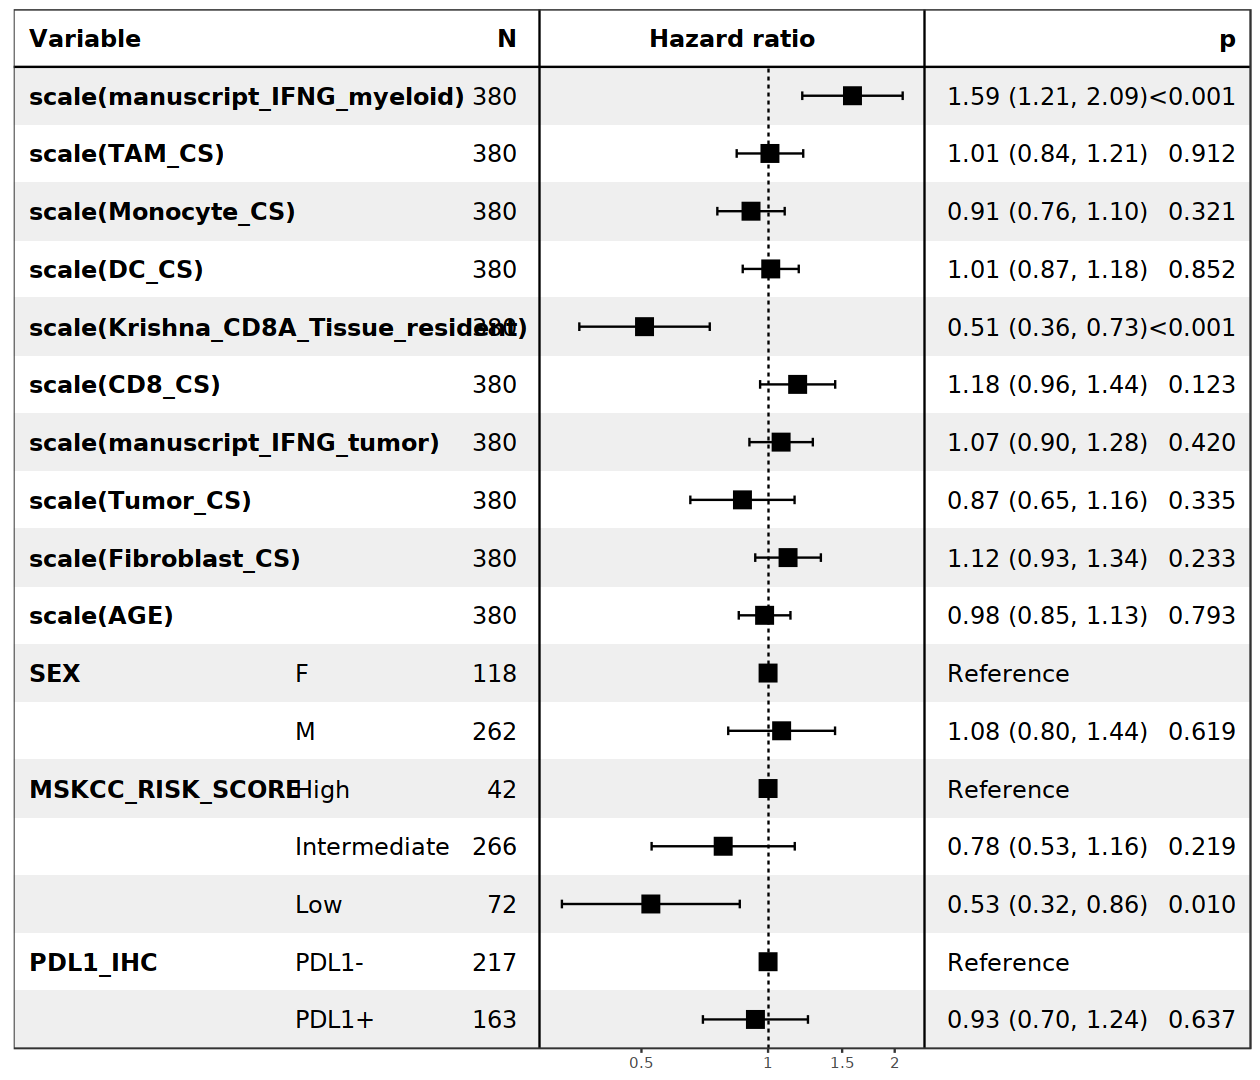

In [6]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_IFNG_atezo_bev_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFNG signatures in sunitinib arm


 CB NCB 
255 123 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3297  -0.9228   0.6007   0.8122   2.1441  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.04204    0.49350  -2.112   0.0347 *  
scale(manuscript_IFNG_myeloid)       0.33919    0.26935   1.259   0.2079    
scale(TAM_CS)                       -0.25851    0.16367  -1.579   0.1142    
scale(Monocyte_CS)                  -0.14346    0.14801  -0.969   0.3324    
scale(DC_CS)                         0.04244    0.15407   0.275   0.7830    
scale(Krishna_CD8A_Tissue_resident)  0.40702    0

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      5.166212 1  2.272930       
scale(TAM_CS)                       1.827928 1  1.352009       
scale(Monocyte_CS)                  1.518255 1  1.232175       
scale(DC_CS)                        1.511061 1  1.229252       
scale(Krishna_CD8A_Tissue_resident) 7.383252 1  2.717214       
scale(CD8_CS)                       3.058204 1  1.748772       
scale(manuscript_IFNG_tumor)        1.611038 1  1.269267       
scale(Tumor_CS)                     3.994240 1  1.998560       
scale(Fibroblast_CS)                1.826647 1  1.351535       
scale(AGE)                          1.077922 1  1.038230       
SEX                                 1.151191 1  1.072936       
MSKCC_RISK_SCORE                    1.072925 2  1.017753       
PDL1_IHC                            1.405338 1  1.185469

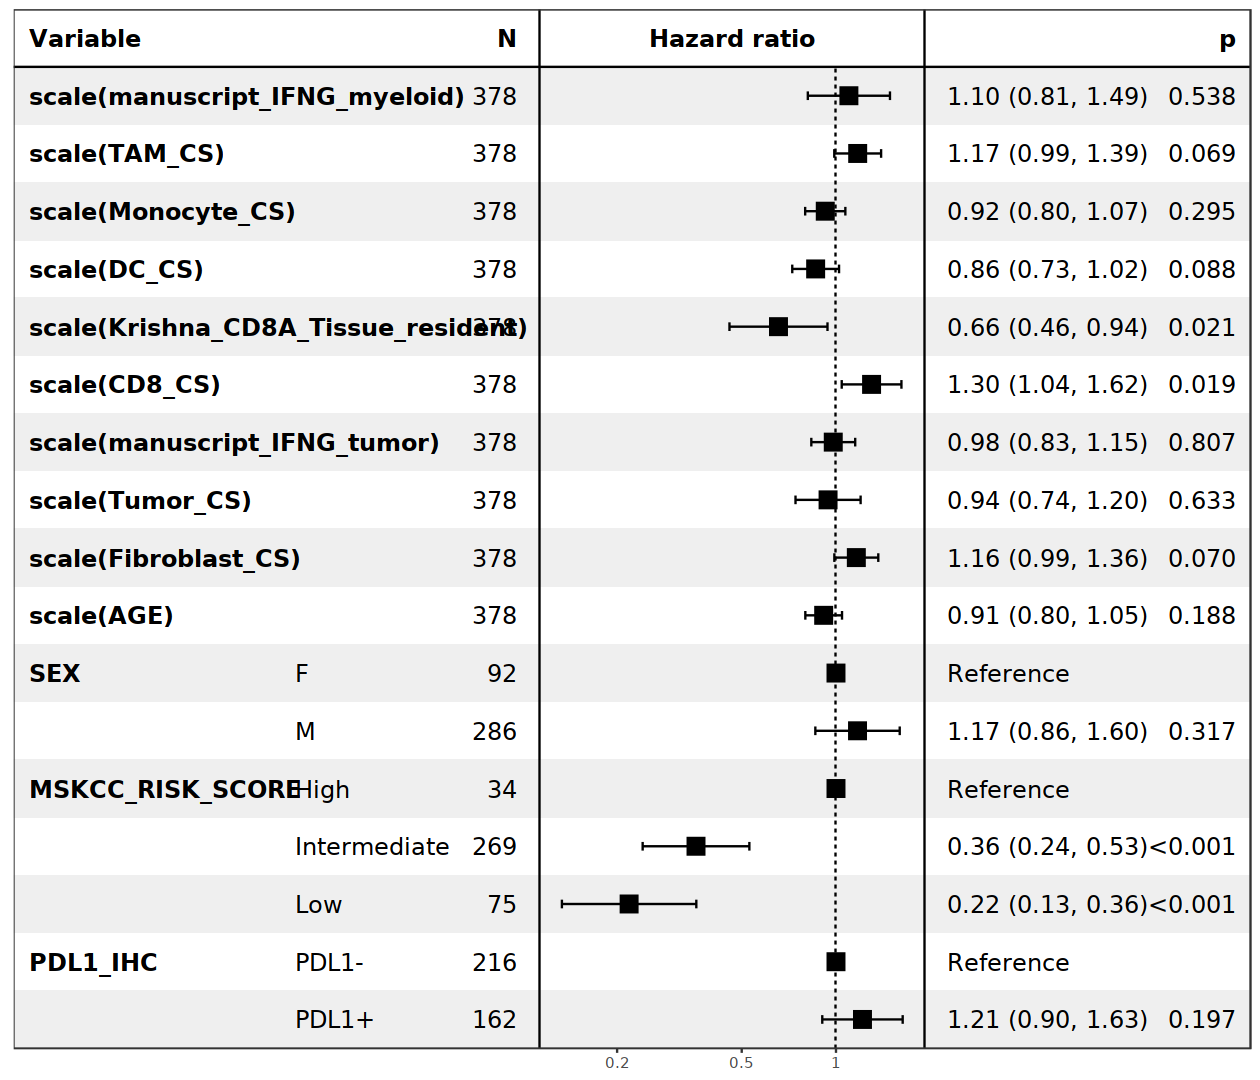

In [7]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_IFNG_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFN1 signatures in atezo_bev arm


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFN1_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2377  -1.1356   0.6577   0.8518   1.5517  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)   
(Intercept)                          0.77308    0.40519   1.908  0.05640 . 
scale(manuscript_IFN1_myeloid)      -0.79802    0.26137  -3.053  0.00226 **
scale(TAM_CS)                       -0.07526    0.17300  -0.435  0.66354   
scale(Monocyte_CS)                   0.10325    0.15725   0.657  0.51144   
scale(DC_CS)                         0.02569    0.15245   0.169  0.86616   
scale(Krishna_CD8A_Tissue_resident)  0.72277    0.30077

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      4.996851 1  2.235364       
scale(TAM_CS)                       2.246607 1  1.498868       
scale(Monocyte_CS)                  1.843180 1  1.357638       
scale(DC_CS)                        1.300169 1  1.140249       
scale(Krishna_CD8A_Tissue_resident) 6.739584 1  2.596071       
scale(CD8_CS)                       2.543126 1  1.594718       
scale(manuscript_IFN1_tumor)        2.023256 1  1.422412       
scale(Tumor_CS)                     4.279080 1  2.068594       
scale(Fibroblast_CS)                1.725728 1  1.313669       
scale(AGE)                          1.165738 1  1.079694       
SEX                                 1.081954 1  1.040170       
MSKCC_RISK_SCORE                    1.126817 2  1.030299       
PDL1_IHC                            1.300350 1  1.140329

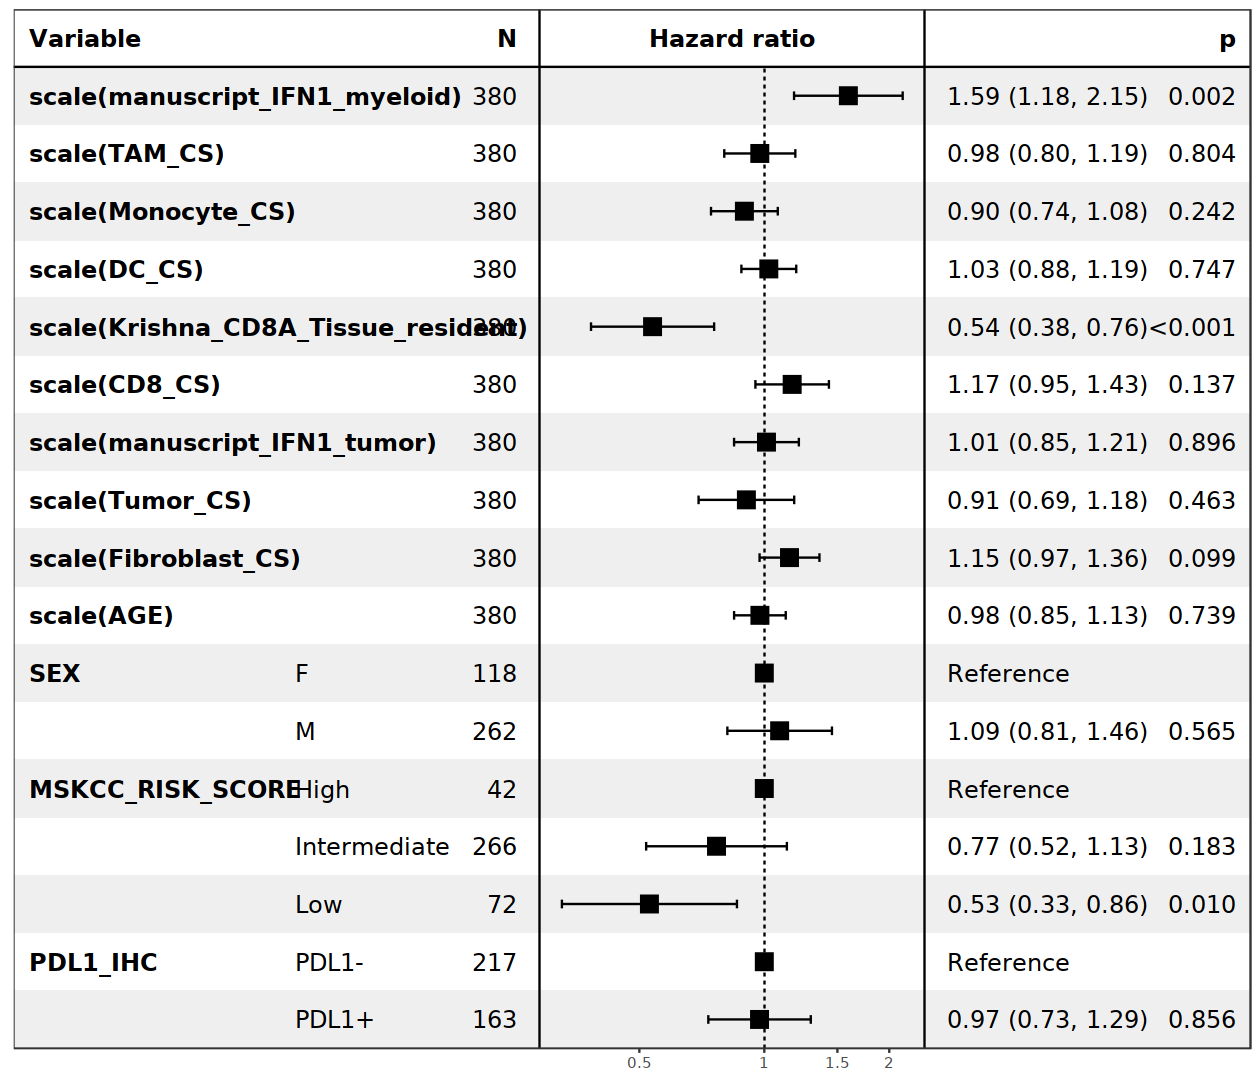

In [8]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_IFN1_atezo_bev_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFN1 signatures in sunitinib arm


 CB NCB 
255 123 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFN1_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3080  -0.9108   0.6042   0.8213   2.1633  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.951135   0.489186  -1.944 0.051857 .  
scale(manuscript_IFN1_myeloid)       0.117930   0.272695   0.432 0.665405    
scale(TAM_CS)                       -0.239075   0.179879  -1.329 0.183818    
scale(Monocyte_CS)                  -0.140714   0.147615  -0.953 0.340463    
scale(DC_CS)                         0.073964   0.150845   0.490 0.623902    
scale(Krishna_CD8A_Tissue_resident)  0.6437

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      5.364241 1  2.316083       
scale(TAM_CS)                       2.235870 1  1.495283       
scale(Monocyte_CS)                  1.515789 1  1.231174       
scale(DC_CS)                        1.435438 1  1.198098       
scale(Krishna_CD8A_Tissue_resident) 6.345128 1  2.518954       
scale(CD8_CS)                       3.044966 1  1.744983       
scale(manuscript_IFN1_tumor)        1.934584 1  1.390893       
scale(Tumor_CS)                     4.740777 1  2.177333       
scale(Fibroblast_CS)                1.706643 1  1.306386       
scale(AGE)                          1.069194 1  1.034018       
SEX                                 1.120814 1  1.058685       
MSKCC_RISK_SCORE                    1.088619 2  1.021454       
PDL1_IHC                            1.384406 1  1.176608

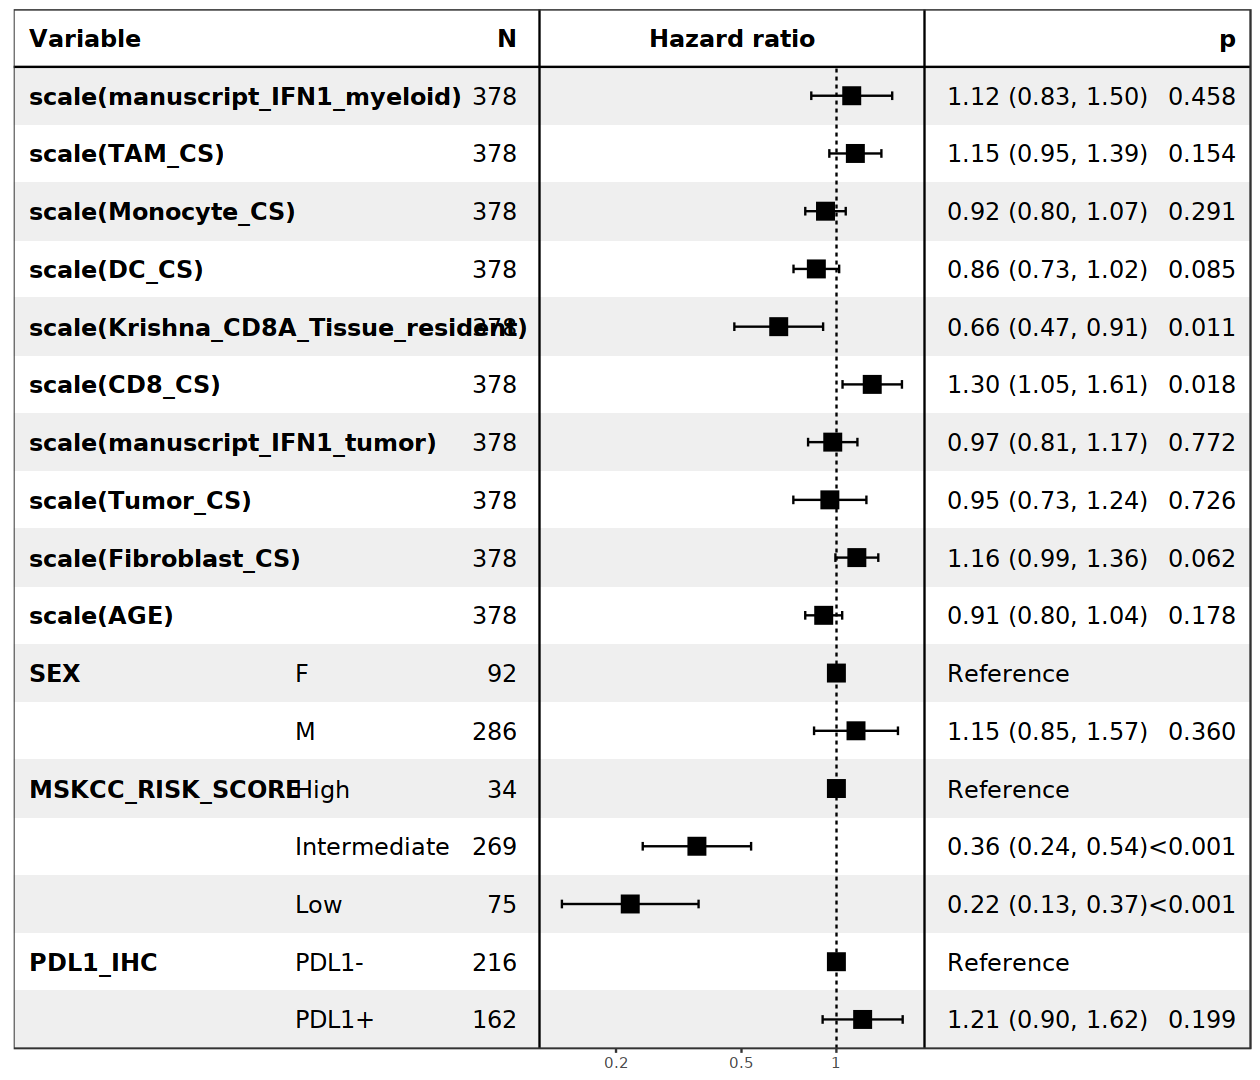

In [9]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_IFN1_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### Combined IFN1 and IFNG signatures in atezo_bev arm


 CB NCB 
263 117 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_tumor_combined) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = atezo_bev)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2726  -1.0967   0.6573   0.8488   1.5702  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)   
(Intercept)                          0.740541   0.403284   1.836  0.06632 . 
scale(manuscript_myeloid_combined)  -0.689480   0.259920  -2.653  0.00799 **
scale(TAM_CS)                       -0.163516   0.161631  -1.012  0.31170   
scale(Monocyte_CS)                   0.066652   0.155089   0.430  0.66736   
scale(DC_CS)                         0.027906   0.152613   0.183  0.85491   
scale(Krishna_CD8A_Tissue_resident)  0.74

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  4.960448 1  2.227206       
scale(TAM_CS)                       1.946696 1  1.395240       
scale(Monocyte_CS)                  1.787622 1  1.337020       
scale(DC_CS)                        1.304257 1  1.142041       
scale(Krishna_CD8A_Tissue_resident) 7.123100 1  2.668914       
scale(CD8_CS)                       2.654738 1  1.629337       
scale(manuscript_tumor_combined)    2.100126 1  1.449181       
scale(Tumor_CS)                     5.040576 1  2.245123       
scale(Fibroblast_CS)                1.858680 1  1.363334       
scale(AGE)                          1.156316 1  1.075321       
SEX                                 1.089920 1  1.043992       
MSKCC_RISK_SCORE                    1.127244 2  1.030397       
PDL1_IHC                            1.315385 1  1.146903

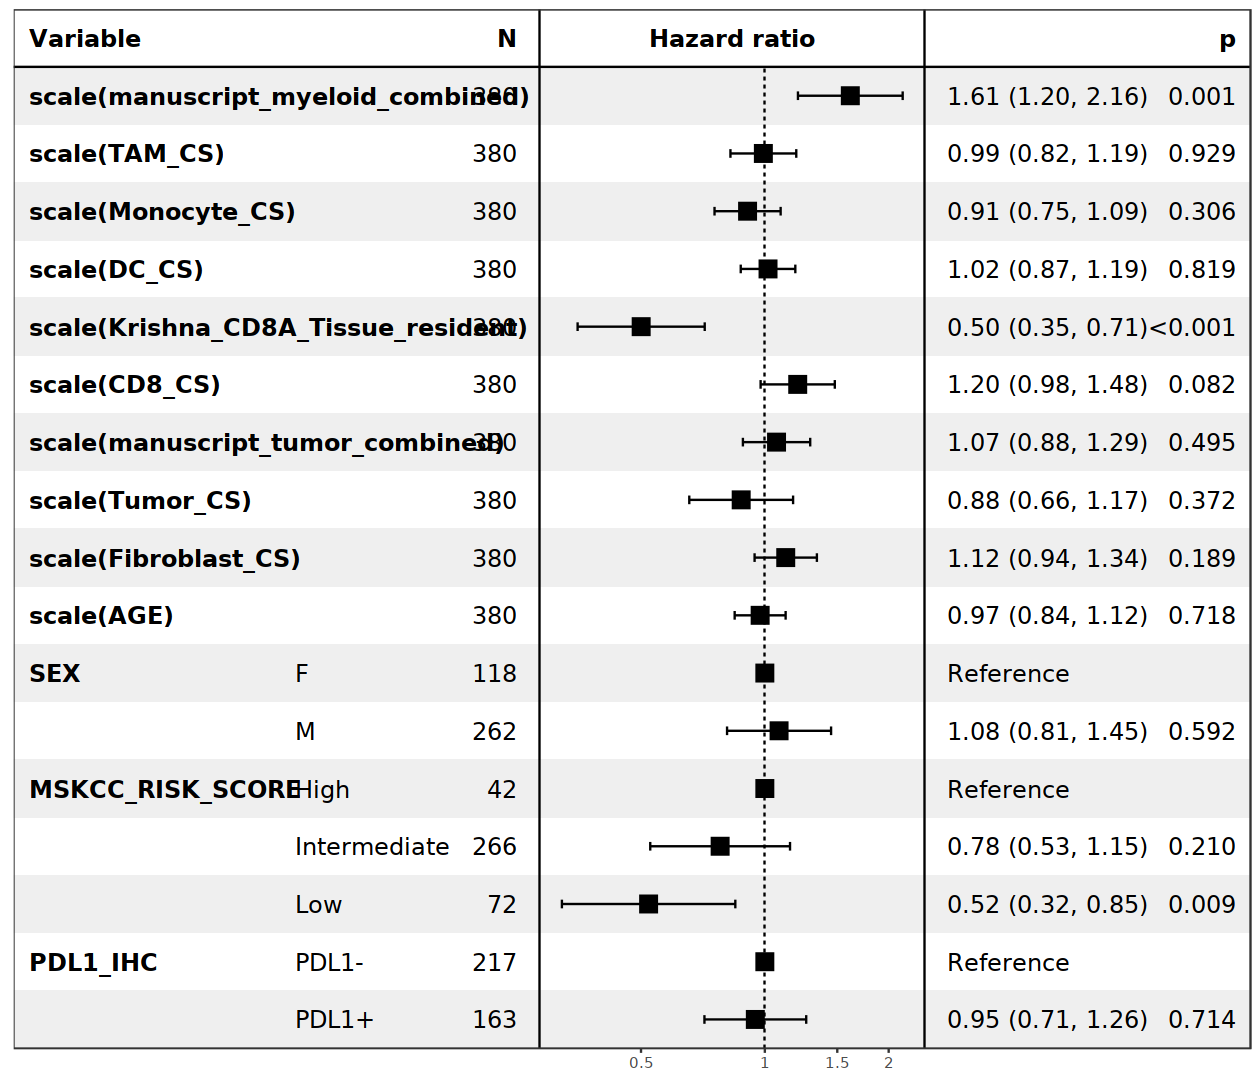

In [10]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_Combined_atezo_bev_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### Combined IFN1 and IFNG signatures in sunitinib arm


 CB NCB 
255 123 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_tumor_combined) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + 
    PDL1_IHC, family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3155  -0.9096   0.5987   0.8073   2.1246  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.04884    0.49381  -2.124   0.0337 *  
scale(manuscript_myeloid_combined)   0.35709    0.27715   1.288   0.1976    
scale(TAM_CS)                       -0.29223    0.17163  -1.703   0.0886 .  
scale(Monocyte_CS)                  -0.14821    0.14826  -1.000   0.3175    
scale(DC_CS)                         0.05069    0.15204   0.333   0.7388    
scale(Krishna_CD8A_Tissue_resident)  0.40

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  5.477348 1  2.340373       
scale(TAM_CS)                       2.014010 1  1.419158       
scale(Monocyte_CS)                  1.521233 1  1.233383       
scale(DC_CS)                        1.473727 1  1.213972       
scale(Krishna_CD8A_Tissue_resident) 7.150370 1  2.674018       
scale(CD8_CS)                       3.062060 1  1.749874       
scale(manuscript_tumor_combined)    1.984205 1  1.408618       
scale(Tumor_CS)                     4.845211 1  2.201184       
scale(Fibroblast_CS)                1.827553 1  1.351870       
scale(AGE)                          1.071440 1  1.035104       
SEX                                 1.122480 1  1.059472       
MSKCC_RISK_SCORE                    1.081023 2  1.019668       
PDL1_IHC                            1.385077 1  1.176893

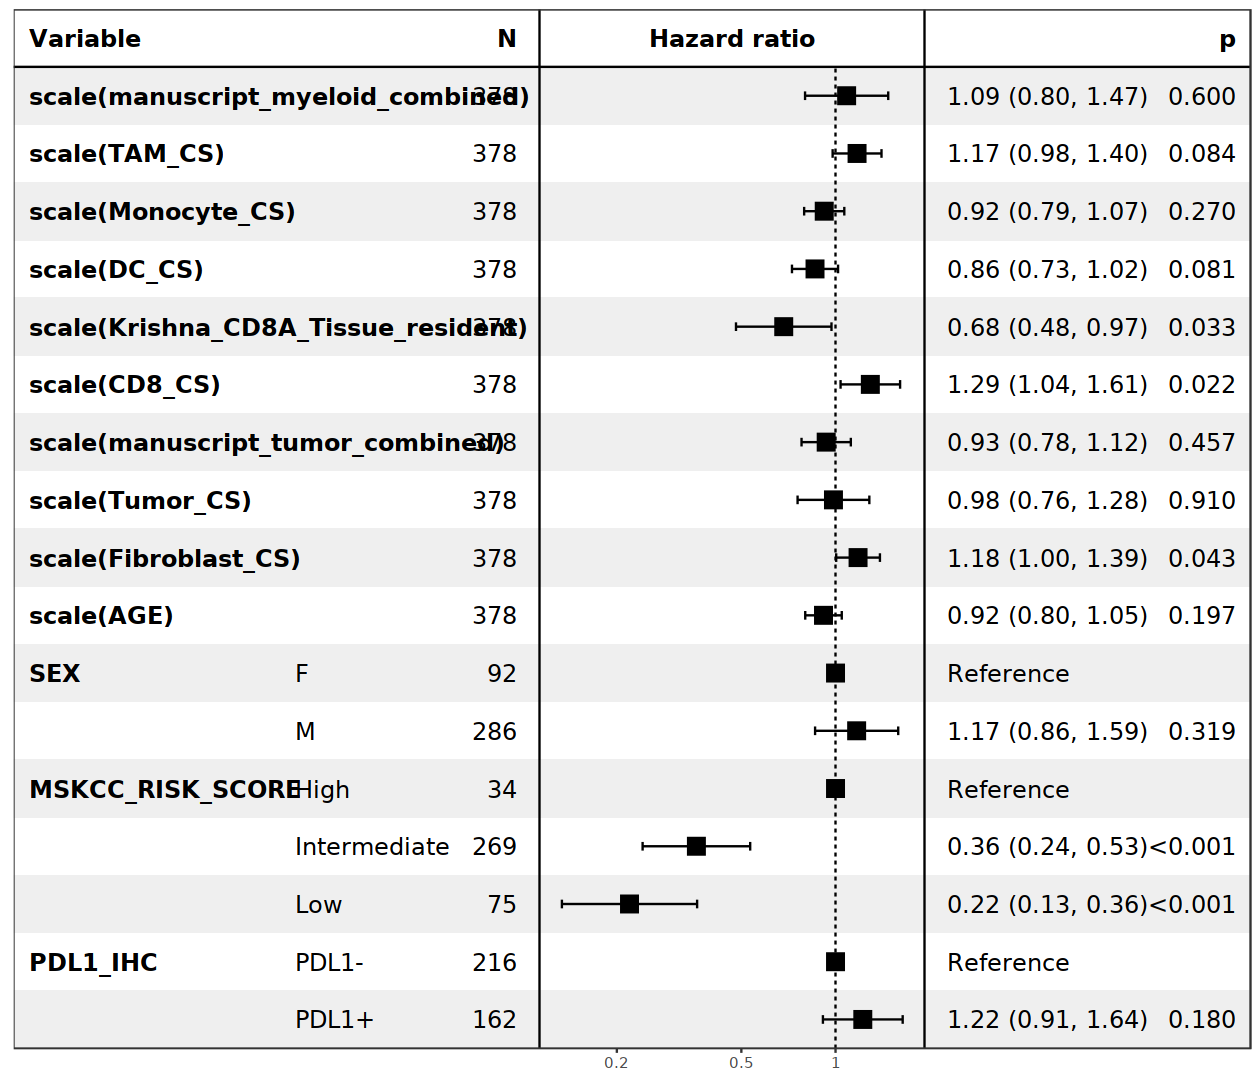

In [11]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS)+ scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib)
forest_model(res.cox, panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4A_IMM151_Combined_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### JAV101

In [12]:
clin_jav101_full = readRDS("../Trial_Cohorts/JAV101/JAV101_Clinical_Metadata_with_SigScores_CIBERSORTx.RDS")

df = data.frame(table(colnames(clin_jav101_full)))
subset(df, Freq > 1)

clin_jav101_full = subset(clin_jav101_full, select = -c(CD8A,Eosinophils,IFIT3, Neutrophils) )

Var1        Freq
14682 CD8A        2   
17979 Eosinophils 2   
21236 IFIT3       2   
27495 Neutrophils 2

### IFNG signatures in avelumab + axitinib arm


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3615  -0.9608   0.6215   0.8209   1.7397  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.614522   0.466390  -1.318 0.187632    
scale(manuscript_IFNG_myeloid)      -0.705695   0.322494  -2.188 0.028652 *  
scale(TAM_CS)                        0.121843   0.185568   0.657 0.511439    
scale(Monocyte_CS)                   0.103238   0.165753   0.623 0.533388    
scale(DC_CS)                         0.001095   0.151486   0.007 0.994232    
scale(Krishna_CD8A_Tissue_resident)  0.713462   

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      6.334491 1  2.516842       
scale(TAM_CS)                       1.945903 1  1.394956       
scale(Monocyte_CS)                  1.608539 1  1.268282       
scale(DC_CS)                        1.423300 1  1.193022       
scale(Krishna_CD8A_Tissue_resident) 7.737760 1  2.781683       
scale(CD8_CS)                       1.786839 1  1.336727       
scale(manuscript_IFNG_tumor)        2.168167 1  1.472470       
scale(Tumor_CS)                     3.635668 1  1.906743       
scale(Fibroblast_CS)                2.053535 1  1.433016       
scale(Age)                          1.054531 1  1.026903       
Sex                                 1.055507 1  1.027379       
MSKCC                               1.131615 2  1.031394       
PDL1_status_v1                      1.198706 1  1.094854

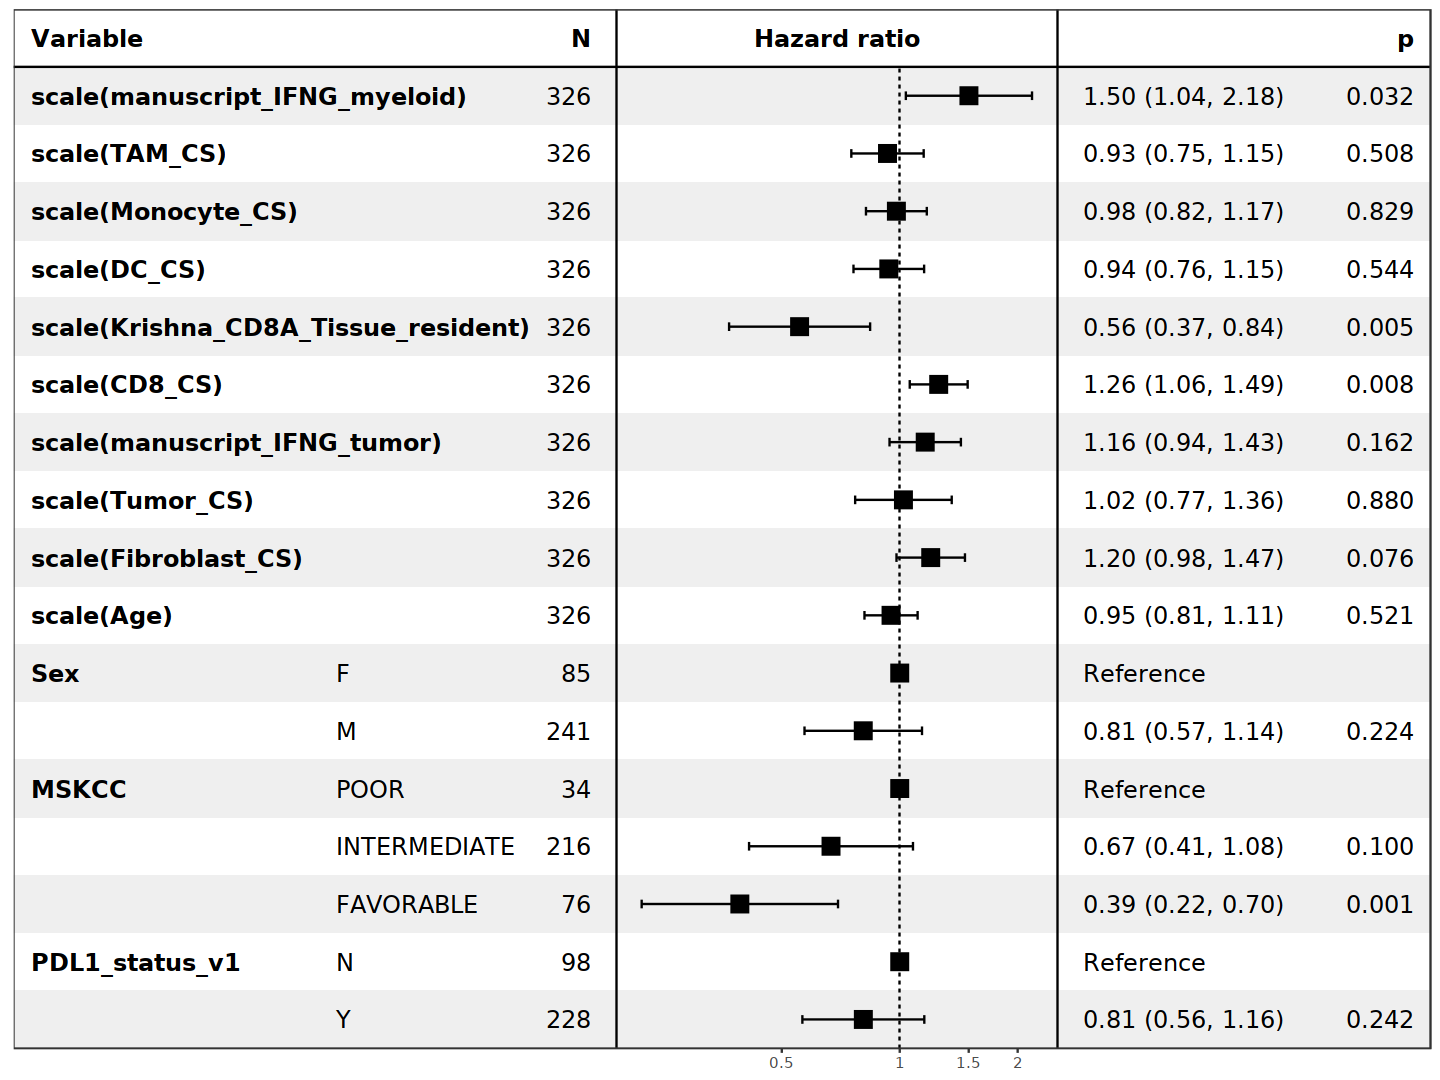

In [13]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_IFNG_avel_axit_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFNG signatures in sunitinib arm


 CB NCB 
182 161 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFNG_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFNG_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9696  -1.1414   0.6366   1.0943   1.9742  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.17963    0.55557  -2.123 0.033731 *  
scale(manuscript_IFNG_myeloid)       0.26436    0.30078   0.879 0.379435    
scale(TAM_CS)                       -0.06943    0.14754  -0.471 0.637939    
scale(Monocyte_CS)                  -0.11769    0.14534  -0.810 0.418098    
scale(DC_CS)                         0.31076    0.15766   1.971 0.048717 *  
scale(Krishna_CD8A_Tissue_resident)  0.05078    0.3230

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFNG_myeloid)      6.698067 1  2.588062       
scale(TAM_CS)                       1.654561 1  1.286297       
scale(Monocyte_CS)                  1.655209 1  1.286549       
scale(DC_CS)                        1.402567 1  1.184300       
scale(Krishna_CD8A_Tissue_resident) 7.716976 1  2.777945       
scale(CD8_CS)                       1.877638 1  1.370269       
scale(manuscript_IFNG_tumor)        2.008667 1  1.417274       
scale(Tumor_CS)                     3.389869 1  1.841160       
scale(Fibroblast_CS)                1.685421 1  1.298238       
scale(Age)                          1.029677 1  1.014730       
Sex                                 1.046710 1  1.023088       
MSKCC                               1.086770 2  1.021020       
PDL1_status_v1                      1.170540 1  1.081915

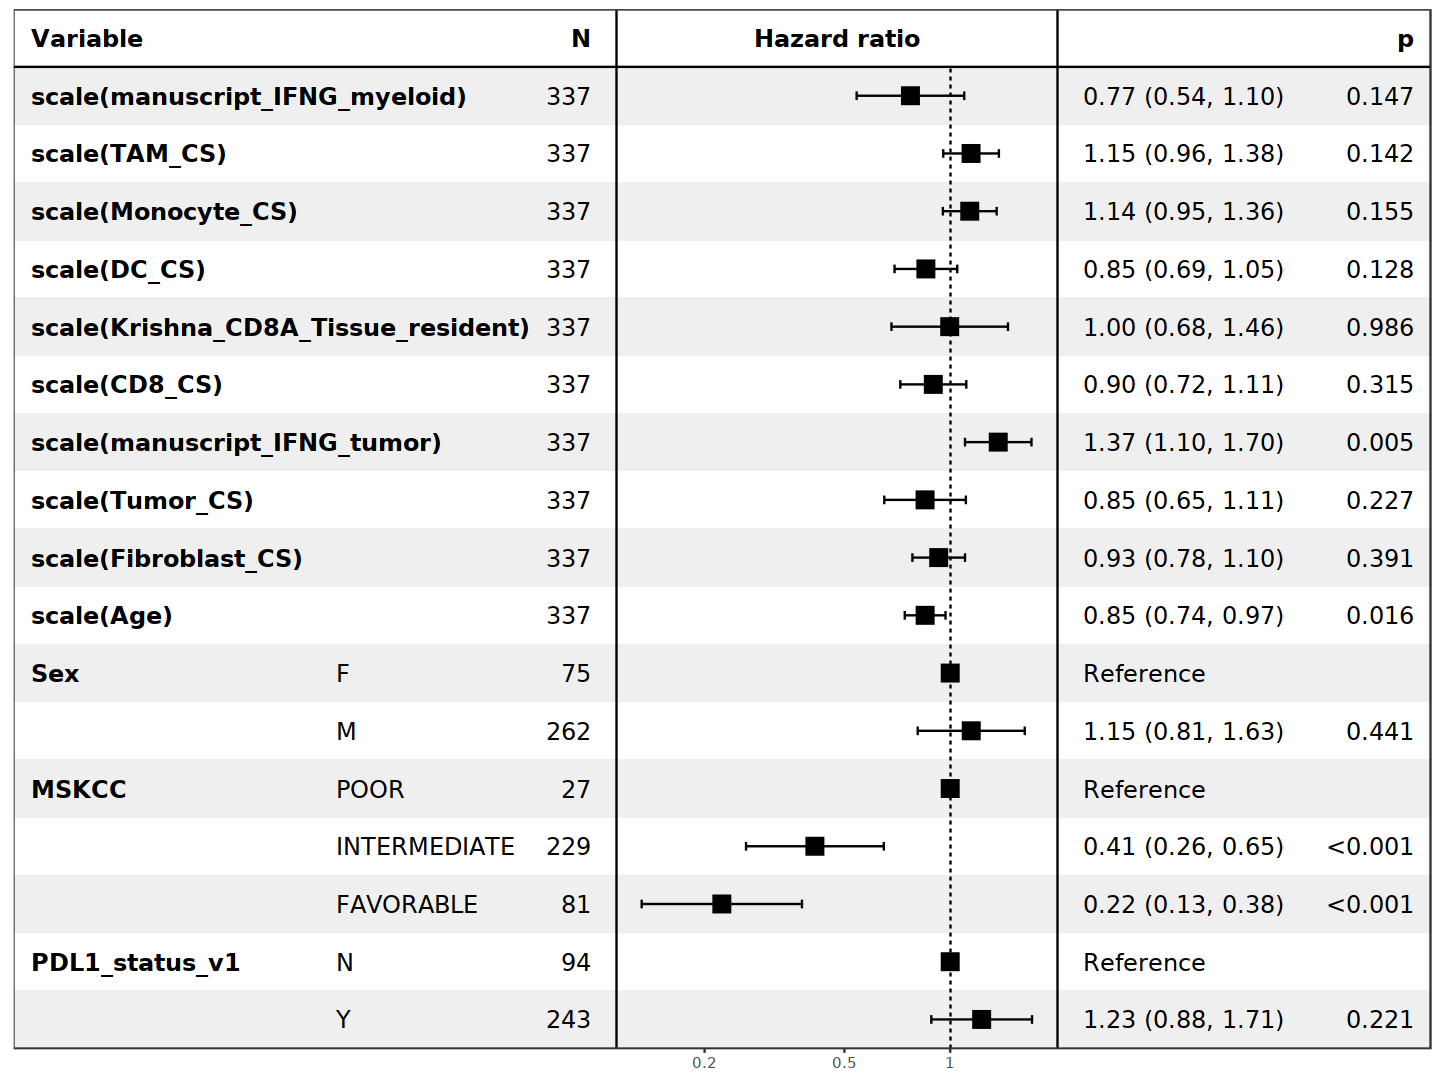

In [14]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFNG_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_IFNG_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFN1 signatures in avelumab + axitinib arm


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFN1_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3469  -0.9861   0.6099   0.8190   1.7719  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.579364   0.467080  -1.240 0.214829    
scale(manuscript_IFN1_myeloid)      -0.666882   0.353015  -1.889 0.058878 .  
scale(TAM_CS)                        0.257223   0.232227   1.108 0.268019    
scale(Monocyte_CS)                   0.106151   0.169184   0.627 0.530378    
scale(DC_CS)                        -0.004749   0.151936  -0.031 0.975067    
scale(Krishna_CD8A_Tissue_resident)  0.583422   

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      7.559508 1  2.749456       
scale(TAM_CS)                       3.060699 1  1.749485       
scale(Monocyte_CS)                  1.686166 1  1.298524       
scale(DC_CS)                        1.433461 1  1.197272       
scale(Krishna_CD8A_Tissue_resident) 6.080146 1  2.465795       
scale(CD8_CS)                       1.695300 1  1.302037       
scale(manuscript_IFN1_tumor)        2.267911 1  1.505959       
scale(Tumor_CS)                     3.313202 1  1.820220       
scale(Fibroblast_CS)                1.682622 1  1.297159       
scale(Age)                          1.052939 1  1.026128       
Sex                                 1.060487 1  1.029799       
MSKCC                               1.120851 2  1.028933       
PDL1_status_v1                      1.188144 1  1.090020

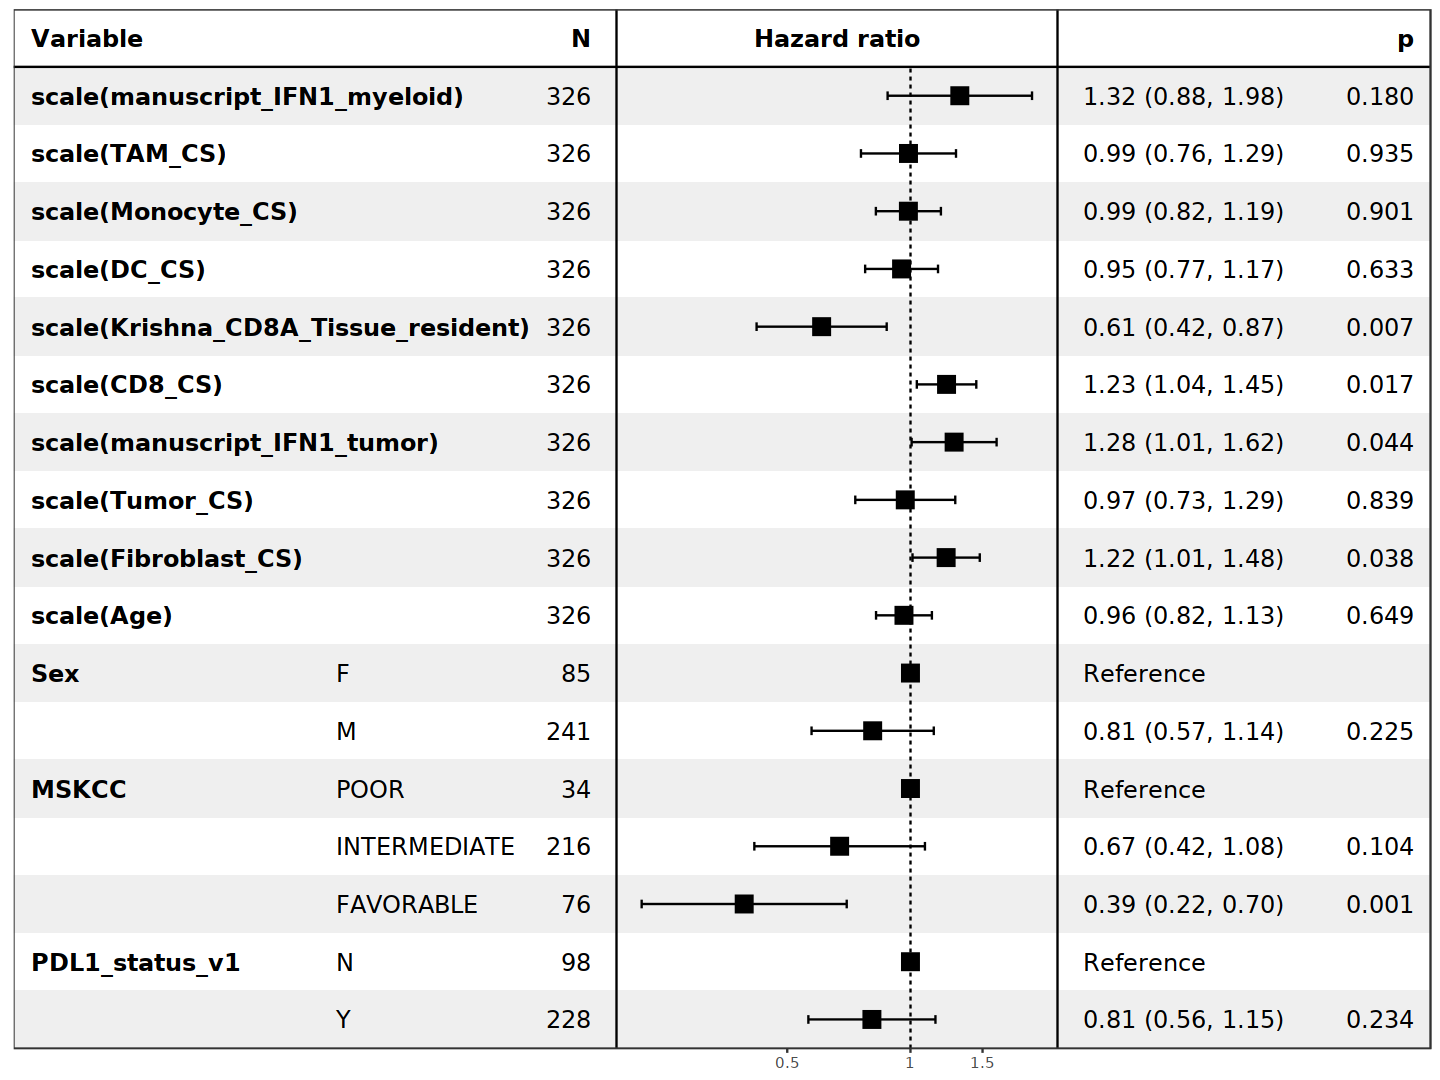

In [15]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_IFN1_avel_axit_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFN1 signatures in sunitinib arm


 CB NCB 
182 161 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_IFN1_myeloid) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_IFN1_tumor) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = sunitinib)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0224  -1.1423   0.6757   1.0924   2.0461  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.196093   0.554173  -2.158 0.030902 *  
scale(manuscript_IFN1_myeloid)       0.009383   0.317764   0.030 0.976443    
scale(TAM_CS)                       -0.040168   0.173450  -0.232 0.816864    
scale(Monocyte_CS)                  -0.073888   0.143870  -0.514 0.607547    
scale(DC_CS)                         0.355269   0.156098   2.276 0.022850 *  
scale(Krishna_CD8A_Tissue_resident)  0.101447   

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_IFN1_myeloid)      7.511371 1  2.740688       
scale(TAM_CS)                       2.303610 1  1.517765       
scale(Monocyte_CS)                  1.627202 1  1.275618       
scale(DC_CS)                        1.359441 1  1.165951       
scale(Krishna_CD8A_Tissue_resident) 6.245856 1  2.499171       
scale(CD8_CS)                       1.805210 1  1.343581       
scale(manuscript_IFN1_tumor)        2.437001 1  1.561090       
scale(Tumor_CS)                     3.805464 1  1.950760       
scale(Fibroblast_CS)                1.425281 1  1.193851       
scale(Age)                          1.028653 1  1.014225       
Sex                                 1.040859 1  1.020225       
MSKCC                               1.076990 2  1.018716       
PDL1_status_v1                      1.171406 1  1.082315

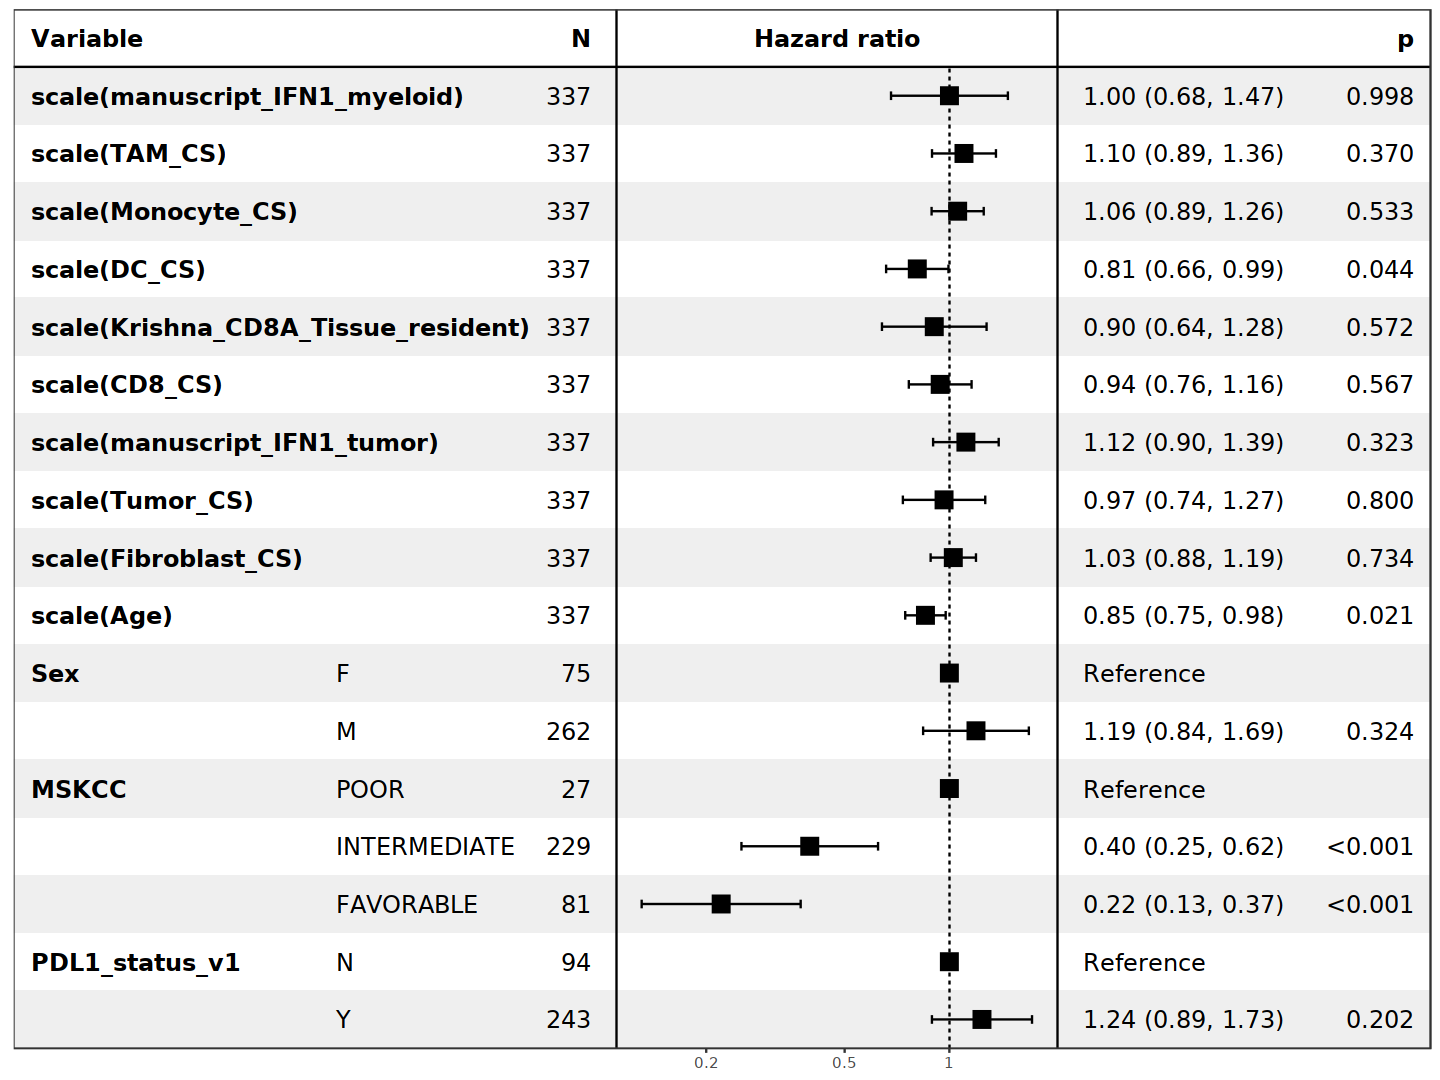

In [16]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_IFN1_myeloid) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFN1_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_IFN1_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### Combined signatures in avelumab + axitinib arm


 CB NCB 
239  96 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_tumor_combined) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = avel_axit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4022  -0.9912   0.6105   0.8248   1.7030  

Coefficients:
                                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -0.585192   0.466391  -1.255 0.209579    
scale(manuscript_myeloid_combined)  -0.767222   0.346025  -2.217 0.026606 *  
scale(TAM_CS)                        0.197741   0.198163   0.998 0.318342    
scale(Monocyte_CS)                   0.116625   0.167682   0.696 0.486734    
scale(DC_CS)                         0.004844   0.152242   0.032 0.974618    
scale(Krishna_CD8A_Tissue_resident)  0.6

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  7.281333 1  2.698394       
scale(TAM_CS)                       2.206870 1  1.485554       
scale(Monocyte_CS)                  1.654013 1  1.286085       
scale(DC_CS)                        1.428038 1  1.195005       
scale(Krishna_CD8A_Tissue_resident) 7.180897 1  2.679720       
scale(CD8_CS)                       1.780896 1  1.334502       
scale(manuscript_tumor_combined)    2.652922 1  1.628779       
scale(Tumor_CS)                     3.974795 1  1.993689       
scale(Fibroblast_CS)                1.890105 1  1.374811       
scale(Age)                          1.051550 1  1.025451       
Sex                                 1.055236 1  1.027247       
MSKCC                               1.127985 2  1.030566       
PDL1_status_v1                      1.192153 1  1.091858

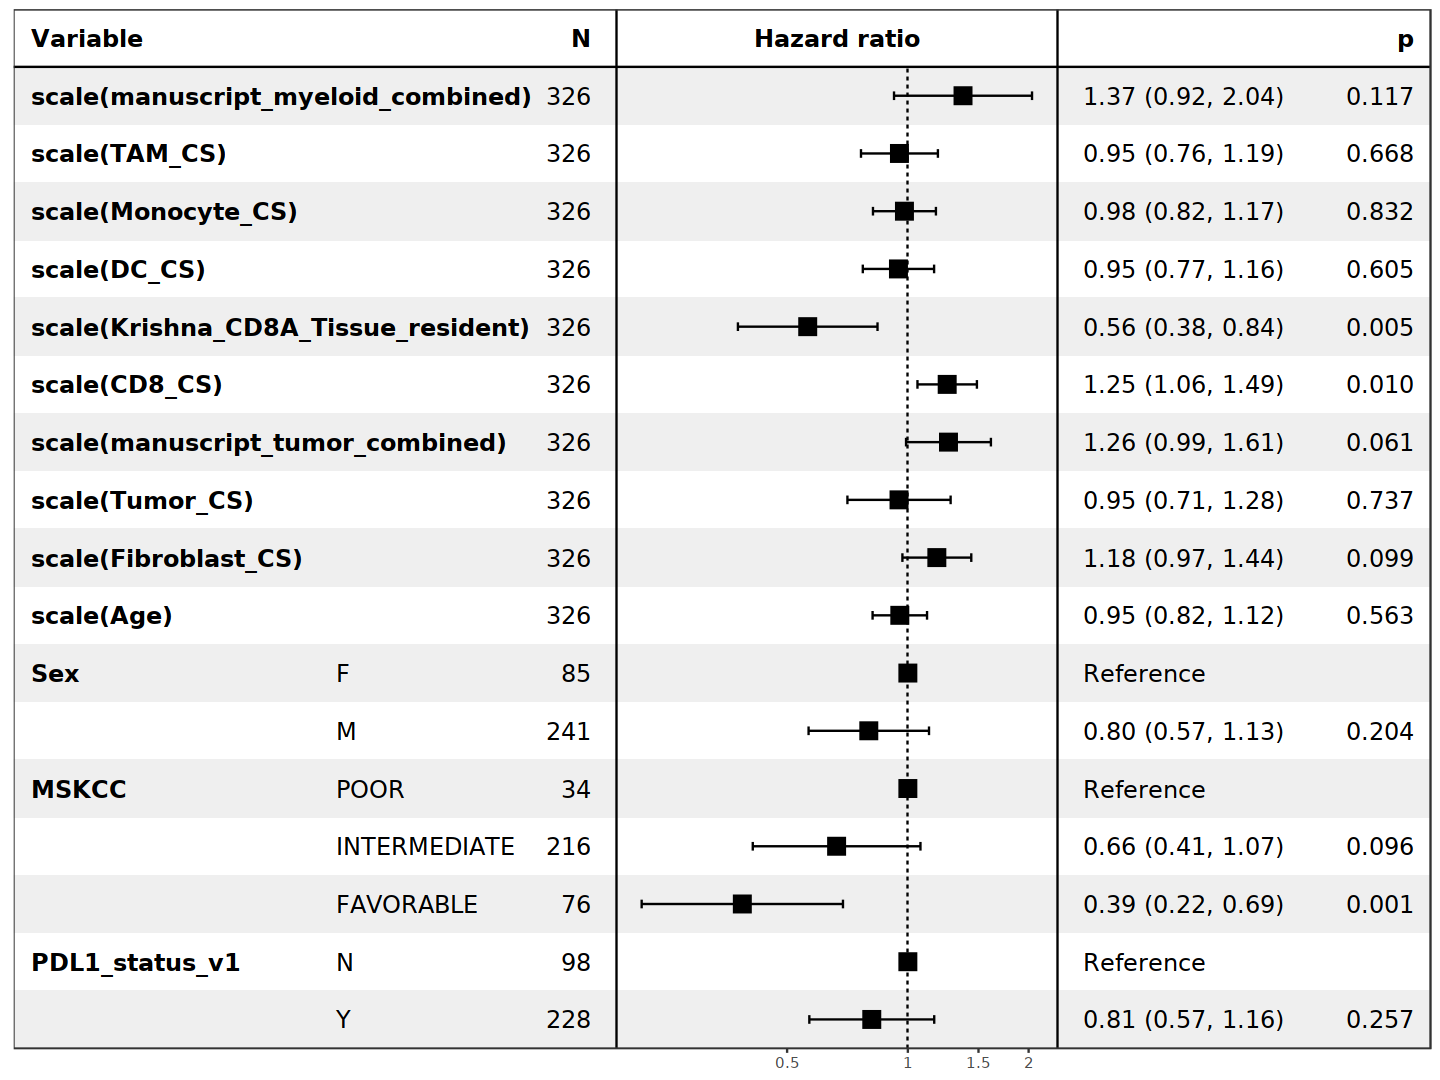

In [17]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_Combined_avel_axit_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### Combined signatures in sunitinib arm


 CB NCB 
182 161 


Call:
glm(formula = Benefit_Binary_Num ~ scale(manuscript_myeloid_combined) + 
    scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + 
    scale(CD8_CS) + scale(manuscript_tumor_combined) + scale(Tumor_CS) + 
    scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, 
    family = "binomial", data = sunitinib)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.981  -1.144   0.688   1.106   2.003  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -1.20268    0.55536  -2.166 0.030344 *  
scale(manuscript_myeloid_combined)   0.18600    0.31951   0.582 0.560471    
scale(TAM_CS)                       -0.08015    0.15708  -0.510 0.609879    
scale(Monocyte_CS)                  -0.09770    0.14496  -0.674 0.500293    
scale(DC_CS)                         0.33660    0.15584   2.160 0.030780 *  
scale(Krishna_CD8A_Tissue_resident)  0.05787    0.31691 

GVIF     Df GVIF^(1/(2*Df))
scale(manuscript_myeloid_combined)  7.575416 1  2.752347       
scale(TAM_CS)                       1.889463 1  1.374577       
scale(Monocyte_CS)                  1.654269 1  1.286184       
scale(DC_CS)                        1.376197 1  1.173114       
scale(Krishna_CD8A_Tissue_resident) 7.465513 1  2.732309       
scale(CD8_CS)                       1.901375 1  1.378903       
scale(manuscript_tumor_combined)    2.512782 1  1.585176       
scale(Tumor_CS)                     4.007629 1  2.001906       
scale(Fibroblast_CS)                1.560510 1  1.249204       
scale(Age)                          1.028357 1  1.014079       
Sex                                 1.045575 1  1.022534       
MSKCC                               1.084380 2  1.020459       
PDL1_status_v1                      1.174039 1  1.083531

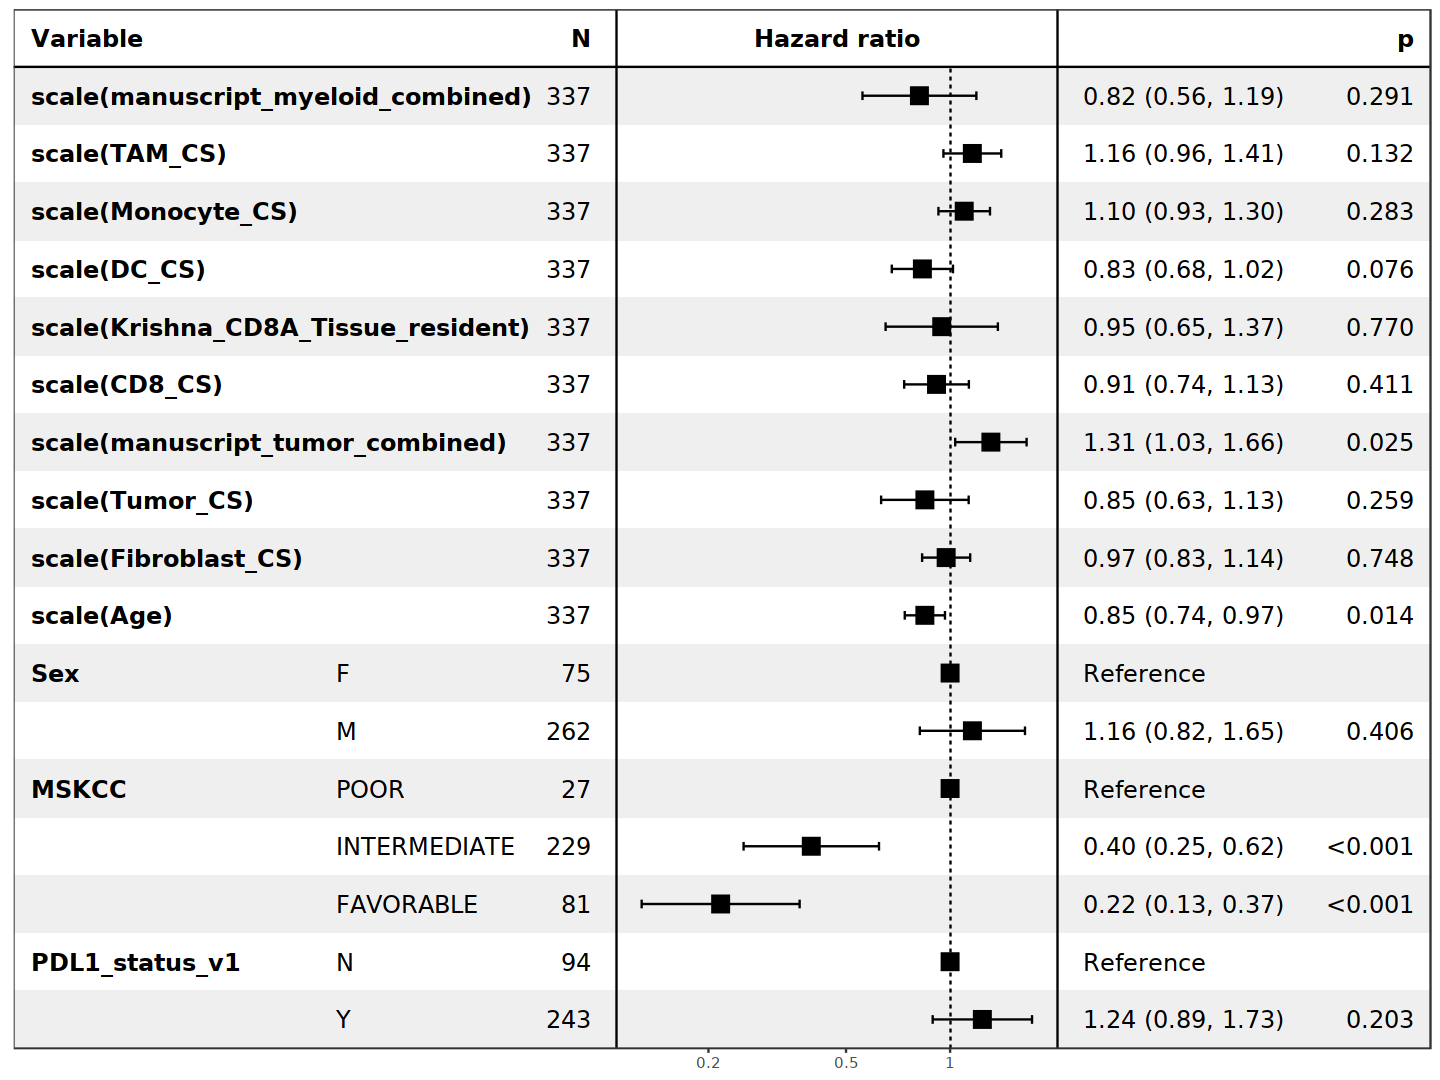

In [18]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))

mylogit <- glm(Benefit_Binary_Num ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = sunitinib)
summary(mylogit)
vif(mylogit)

options(repr.plot.width=12, repr.plot.height=9)
res.cox <- coxph(Surv(PFS, PFS_CNSR) ~  scale(manuscript_myeloid_combined) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_tumor_combined)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib)
forest_model(res.cox,panels,recalculate_width = F)

ggsave("../Figures/Figure4/Figure4C_JAV101_Combined_sunitinib_Continuous_CoxPH_Scaled.pdf", width = 10.5, height = 9)

### IFNG myeloid signature, and not IFN1 or IFNG/IFN1 combined, is consistently associated with worse outcome (PFS and lack of clinical benefit) in both IMM151 and JAV101

### Figure 4B and 4D. Survival curves for PFS in IO+VEGF vs VEGF arms of IMM151 and JAV101 <a name="2"></a>

### IMM151

In [19]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

In [20]:
options(repr.plot.width=10.5, repr.plot.height=9)

clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
sunitinib = subset(clin_imm151_full, ARM == "sunitinib")

sunitinib = subset(sunitinib, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
255 123 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score

cutpoint  statistic
Krishna_CD8A_Tissue_resident -4.336211 3.127211

$Krishna_CD8A_Tissue_resident


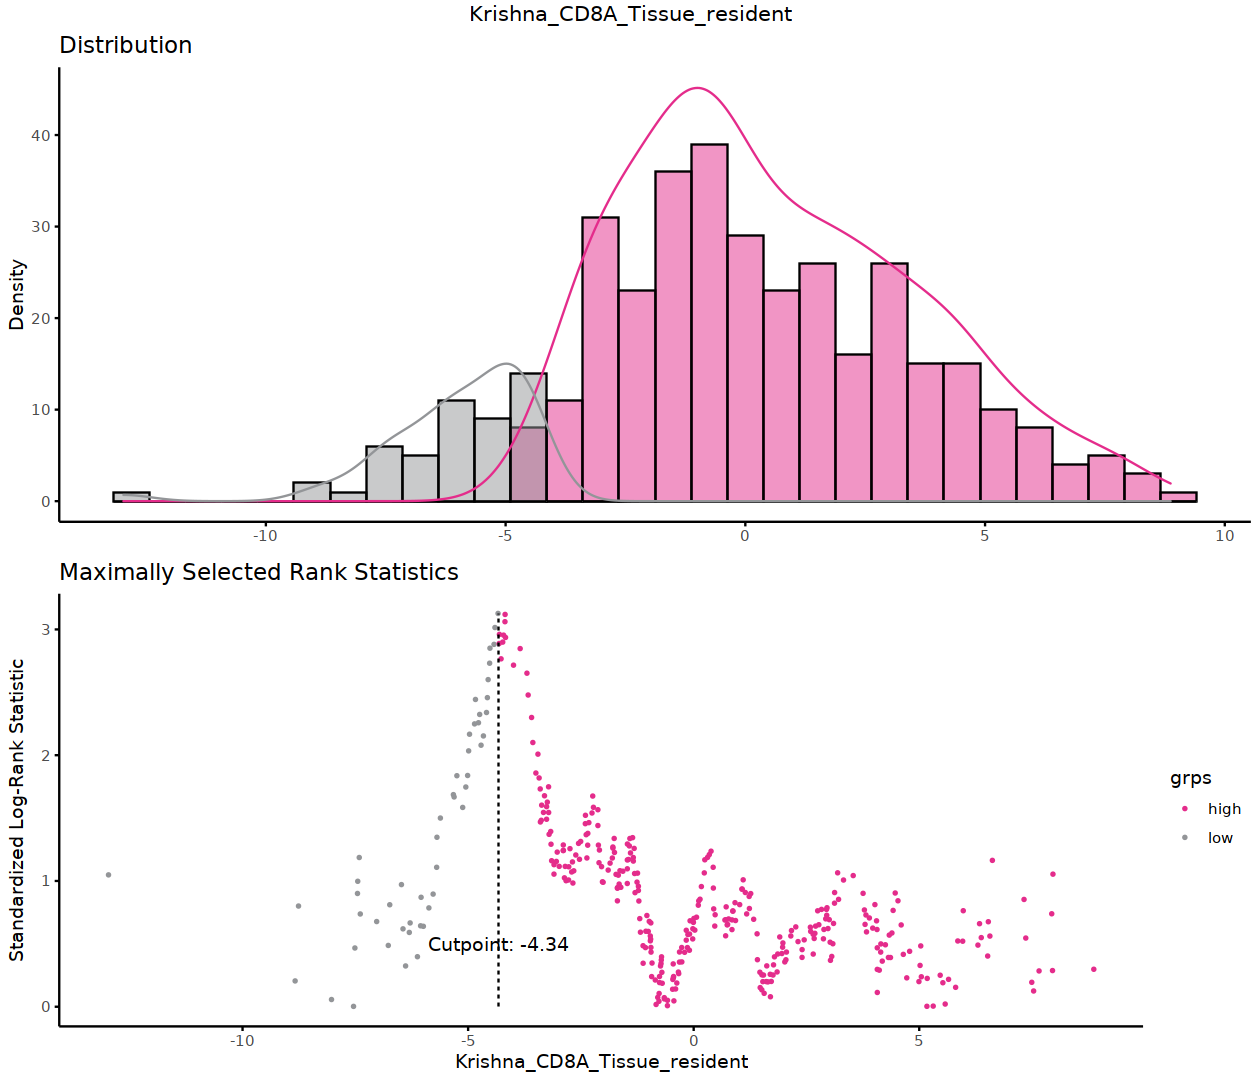

In [21]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(atezo_bev, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [22]:
atezo_bev_topcd8 = subset(atezo_bev, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(atezo_bev_topcd8)

[1]   331 25639

In [23]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   342 25639

cutpoint  statistic
manuscript_IFNG_myeloid -1.879233 3.637437

$manuscript_IFNG_myeloid


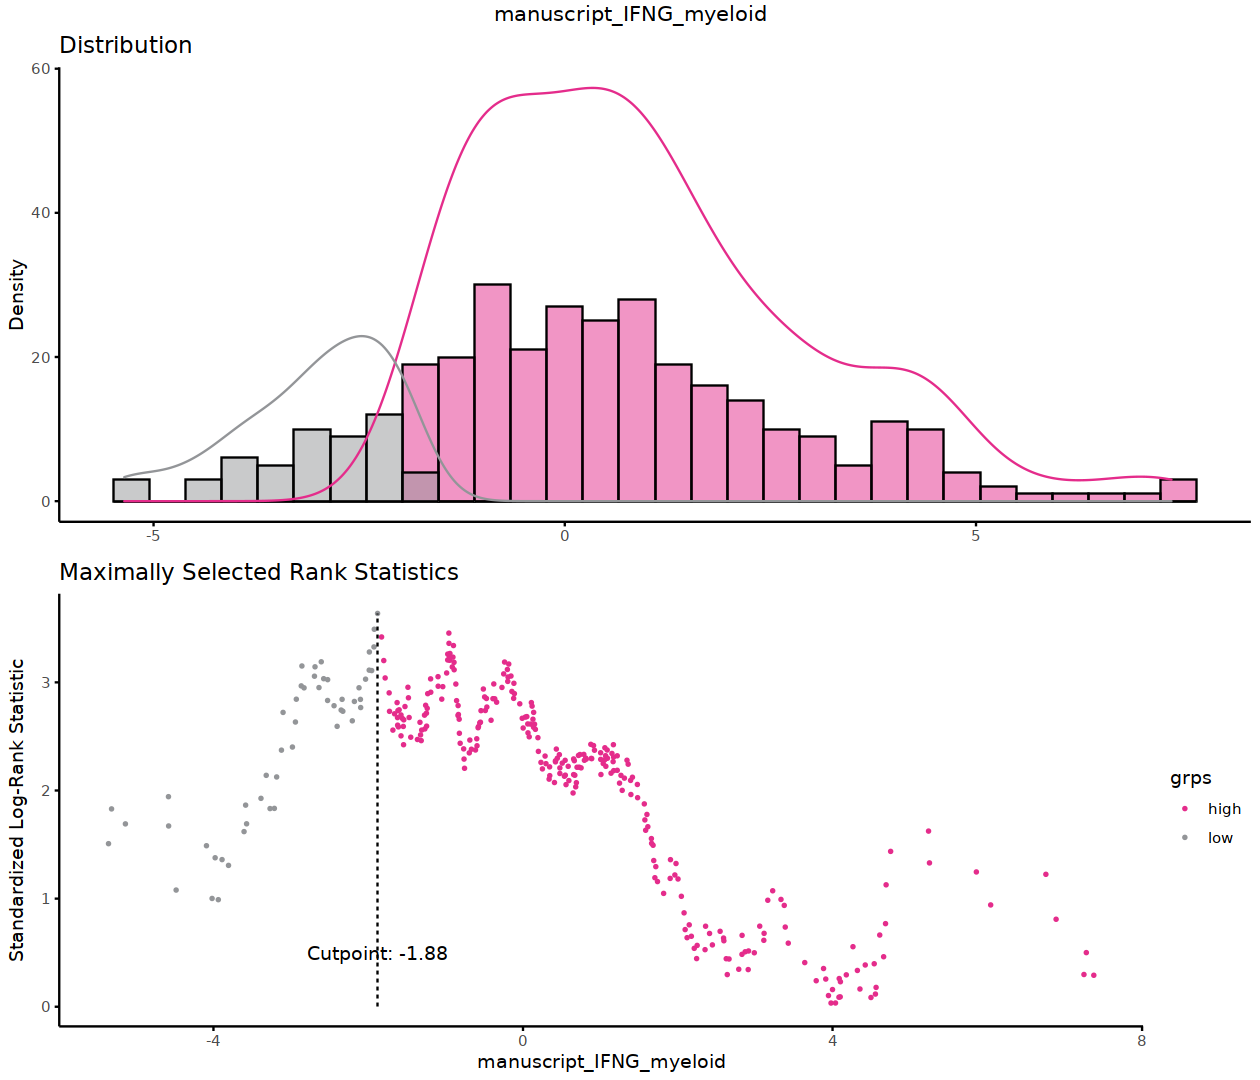

In [24]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(atezo_bev_topcd8, time = "PFS_MONTHS", event = "PFS_CENSOR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [25]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

PFS_MONTHS PFS_CENSOR manuscript_IFNG_myeloid
EA-c98e425b64 11.43       TRUE      high                   
EA-50a17b762a  9.76       TRUE      high                   
EA-503b2e1876 11.24      FALSE      low                    
EA-9be3b7c254 23.39      FALSE      low                    
EA-cce8886053  2.07       TRUE      high                   
EA-858e45ba5f 11.17       TRUE      high

[1] 331   3


high  low 
 279   52 

In [26]:
res.cut_myeloid$cutpoint$cutpoint

[1] -1.879233

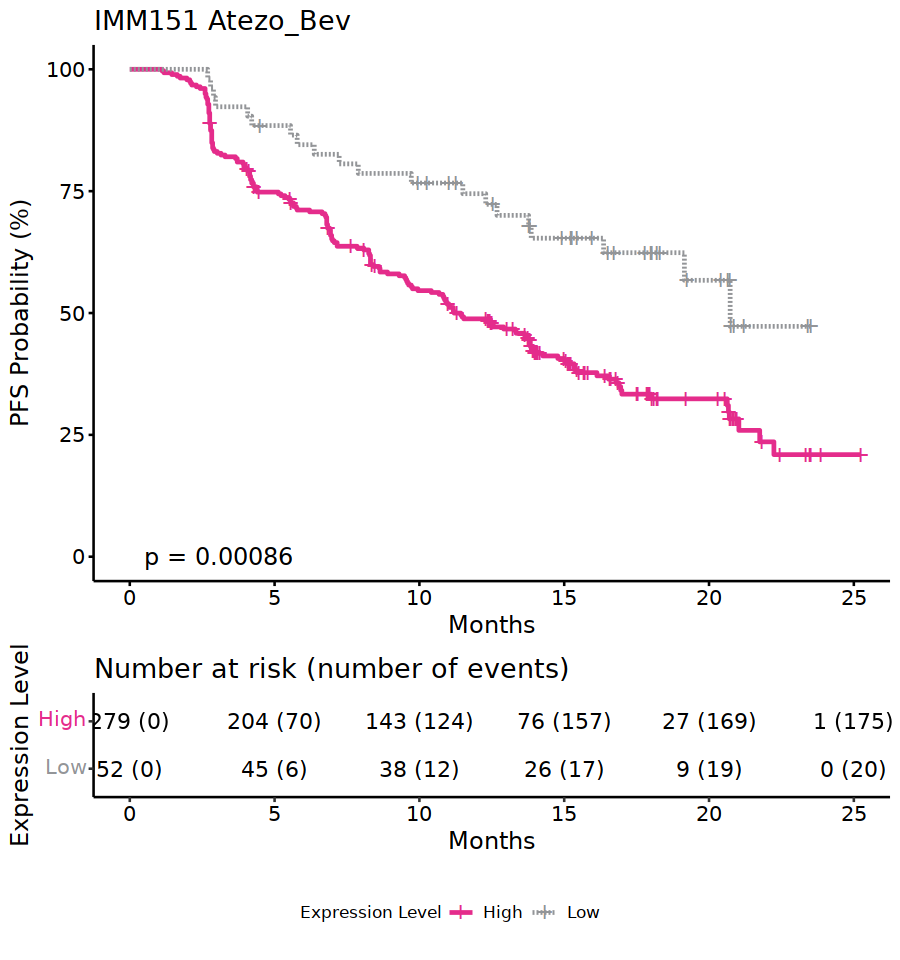

In [27]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "IMM151 Atezo_Bev",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
io

In [28]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 299   43 

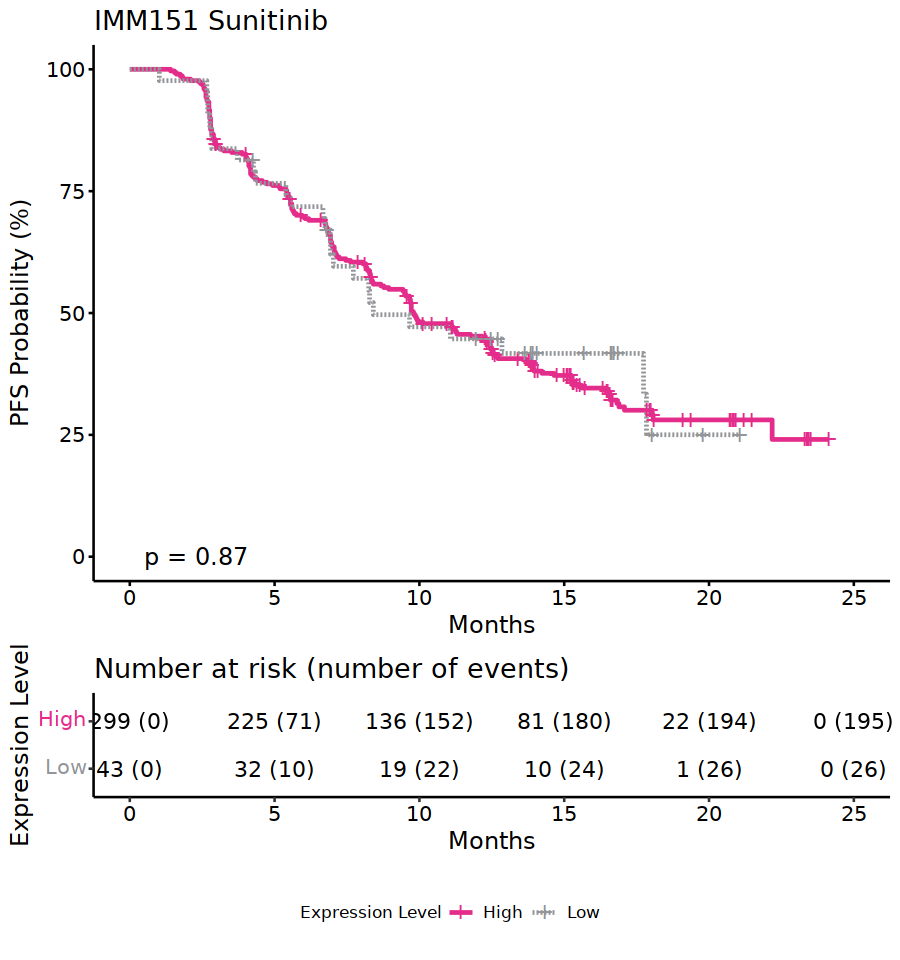

In [29]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS_MONTHS, PFS_CENSOR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "IMM151 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [30]:
setequal(row.names(res.cat), row.names(atezo_bev_topcd8))

[1] TRUE

In [31]:
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
atezo_bev_topcd8$manuscript_IFNG_myeloid_group = factor(atezo_bev_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(atezo_bev_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  52  279 

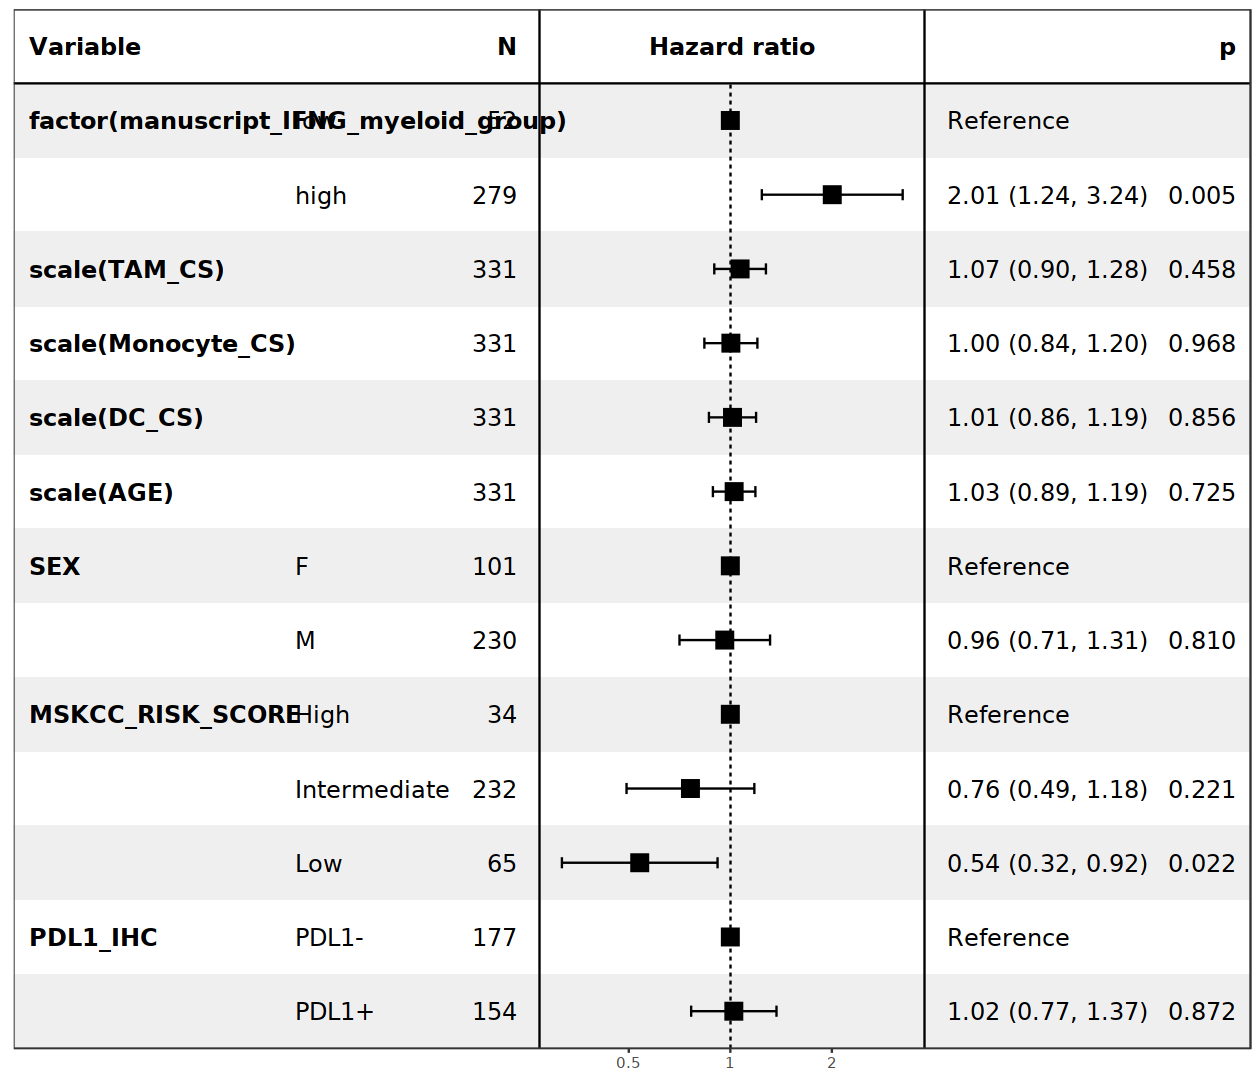

In [32]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

### Sunitinib arm

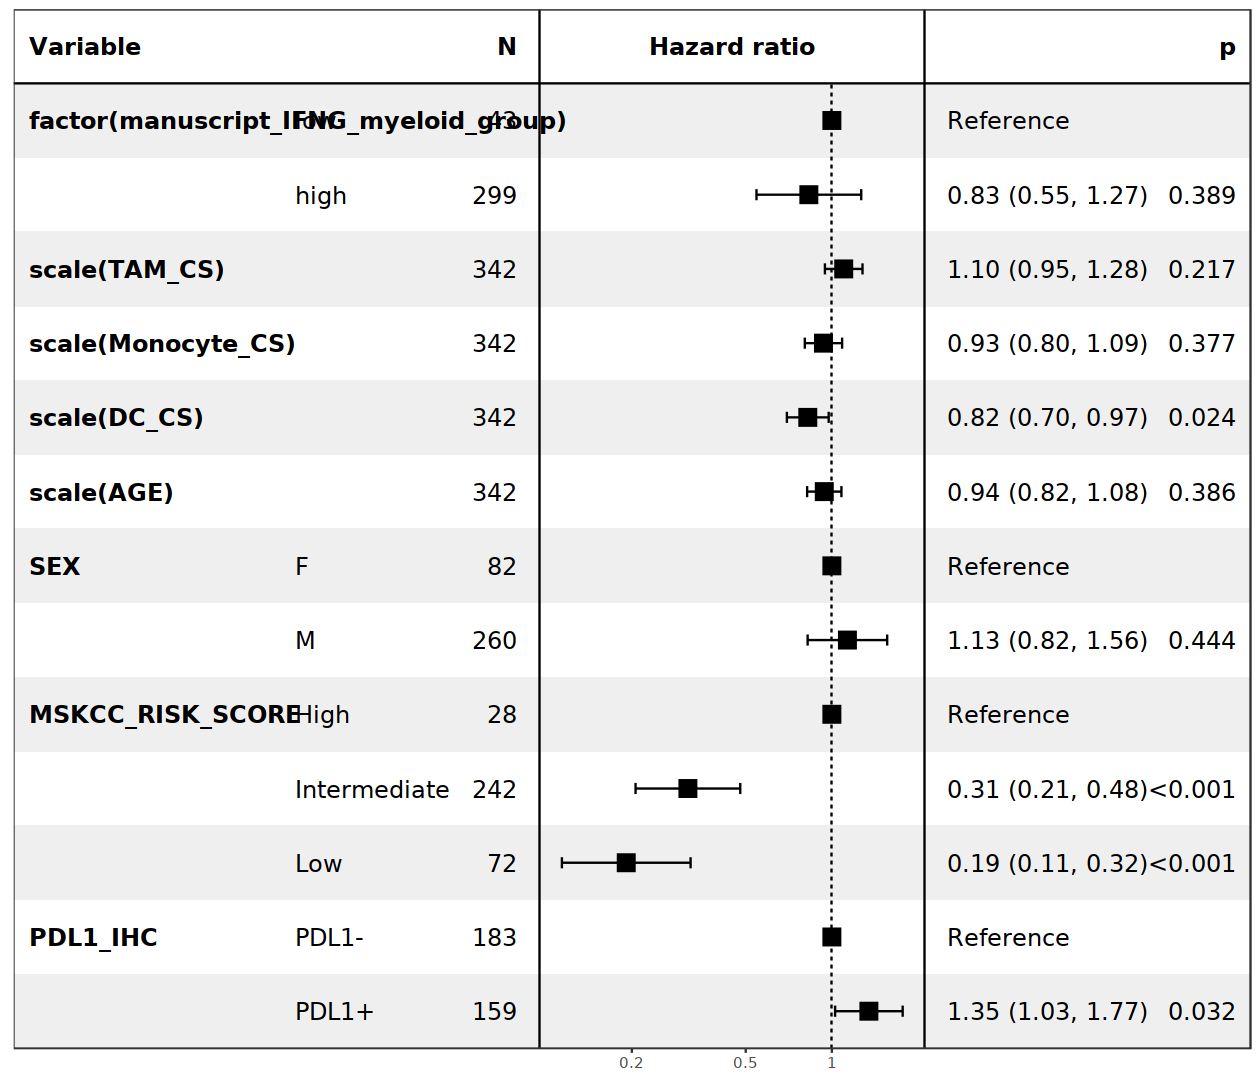

In [33]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

### Plot IO+VEGF and VEGF arms together with hazard ratios and p-values for multi and univariate analyses and export. For the multivariate analysis, we will use only myeloid IFNG signalling, myeloid cibersort fractions, and clinicopathological variables.

In [34]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev_topcd8)
summary(res.cox)$coefficients

imm151_atezo_bev_topcd8_MVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(imm151_atezo_bev_topcd8_MVA) = c("HR","p")
imm151_atezo_bev_topcd8_MVA

coef         exp(coef) se(coef)  
factor(manuscript_IFNG_myeloid_group)high  0.695803203 2.0053191 0.24527913
scale(TAM_CS)                              0.066729353 1.0690061 0.08996324
scale(Monocyte_CS)                         0.003724694 1.0037316 0.09234151
scale(DC_CS)                               0.014864061 1.0149751 0.08212114
scale(AGE)                                 0.026068423 1.0264112 0.07400373
SEXM                                      -0.037915557 0.9627942 0.15774804
MSKCC_RISK_SCOREIntermediate              -0.272280188 0.7616408 0.22256036
MSKCC_RISK_SCORELow                       -0.618478160 0.5387637 0.27104103
PDL1_IHCPDL1+                              0.023889374 1.0241770 0.14858831
                                          z           Pr(>|z|)   
factor(manuscript_IFNG_myeloid_group)high  2.83678116 0.004557083
scale(TAM_CS)                              0.74174020 0.458244758
scale(Monocyte_CS)                         0.04033608 0.967825193
scale(DC_CS)                               0.18100163 0.856366299
scale(AGE)                                 0.35225822 0.724644621
SEXM                                      -0.24035517 0.810054927
MSKCC_RISK_SCOREIntermediate              -1.22339927 0.221178928
MSKCC_RISK_SCORELow                       -2.28186177 0.022497503
PDL1_IHCPDL1+                              0.16077559 0.872270148

HR           p 
2.005319106 0.004557083

In [35]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group), data = atezo_bev_topcd8)
summary(res.cox)$coefficients


imm151_atezo_bev_topcd8_UVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(imm151_atezo_bev_topcd8_UVA) = c("HR","p")
imm151_atezo_bev_topcd8_UVA

coef      exp(coef) se(coef) z       
factor(manuscript_IFNG_myeloid_group)high 0.7690064 2.157621  0.236505 3.251544
                                          Pr(>|z|)   
factor(manuscript_IFNG_myeloid_group)high 0.001147801

HR           p 
2.157621464 0.001147801

In [36]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = sunitinib_topcd8)
summary(res.cox)$coefficients


imm151_sunitinib_topcd8_MVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(imm151_sunitinib_topcd8_MVA) = c("HR","p")
imm151_sunitinib_topcd8_MVA

coef        exp(coef) se(coef)  
factor(manuscript_IFNG_myeloid_group)high -0.18529679 0.8308577 0.21502549
scale(TAM_CS)                              0.09528926 1.0999770 0.07717723
scale(Monocyte_CS)                        -0.06771313 0.9345285 0.07659186
scale(DC_CS)                              -0.19385058 0.8237810 0.08579760
scale(AGE)                                -0.06107040 0.9407570 0.07040765
SEXM                                       0.12510729 1.1332700 0.16329390
MSKCC_RISK_SCOREIntermediate              -1.15854042 0.3139441 0.21493767
MSKCC_RISK_SCORELow                       -1.65471236 0.1911470 0.26416045
PDL1_IHCPDL1+                              0.29789661 1.3470225 0.13872942
                                          z          Pr(>|z|)    
factor(manuscript_IFNG_myeloid_group)high -0.8617434 3.888288e-01
scale(TAM_CS)                              1.2346811 2.169492e-01
scale(Monocyte_CS)                        -0.8840773 3.766545e-01
scale(DC_CS)                              -2.2593940 2.385888e-02
scale(AGE)                                -0.8673831 3.857321e-01
SEXM                                       0.7661480 4.435883e-01
MSKCC_RISK_SCOREIntermediate              -5.3901228 7.040956e-08
MSKCC_RISK_SCORELow                       -6.2640428 3.751224e-10
PDL1_IHCPDL1+                              2.1473210 3.176773e-02

HR         p 
0.8308577 0.3888288

In [37]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ factor(manuscript_IFNG_myeloid_group), data = sunitinib_topcd8)
summary(res.cox)$coefficients


imm151_sunitinib_topcd8_UVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(imm151_sunitinib_topcd8_UVA) = c("HR","p")
imm151_sunitinib_topcd8_UVA

coef       exp(coef) se(coef) 
factor(manuscript_IFNG_myeloid_group)high 0.03479823 1.035411  0.2089199
                                          z         Pr(>|z|) 
factor(manuscript_IFNG_myeloid_group)high 0.1665625 0.8677143

HR         p 
1.0354108 0.8677143

In [38]:
label_MVA_io = paste("HR = ",round(imm151_atezo_bev_topcd8_MVA["HR"],2), ", p = ", round(imm151_atezo_bev_topcd8_MVA["p"],3), " (MVA)",sep = "")
label_UVA_io = paste("HR = ",round(imm151_atezo_bev_topcd8_UVA["HR"],2), ", p = ", round(imm151_atezo_bev_topcd8_UVA["p"],3), " (UVA)",sep = "")
label_MVA_io
label_UVA_io

[1] "HR = 2.01, p = 0.005 (MVA)"

[1] "HR = 2.16, p = 0.001 (UVA)"

In [39]:
label_MVA_tki = paste("HR = ",round(imm151_sunitinib_topcd8_MVA["HR"],2), ", p = ", round(imm151_sunitinib_topcd8_MVA["p"],3), " (MVA)",sep = "")
label_UVA_tki = paste("HR = ",round(imm151_sunitinib_topcd8_UVA["HR"],2), ", p = ", round(imm151_sunitinib_topcd8_UVA["p"],3), " (UVA)",sep = "")
label_MVA_tki
label_UVA_tki

[1] "HR = 0.83, p = 0.389 (MVA)"

[1] "HR = 1.04, p = 0.868 (UVA)"

In [40]:
io_labeled = io$plot + ggplot2::annotate(
    "text",
    x = Inf, y = Inf,
    vjust = 1, hjust = 1,
    label = paste(label_MVA_io, " \n ",label_UVA_io, sep = ""),
    size = 5
  )

In [41]:
tki_labeled = tki$plot + ggplot2::annotate(
    "text",
    x = Inf, y = Inf,
    vjust = 1, hjust = 1,
    label = paste(label_MVA_tki, " \n ",label_UVA_tki, sep = ""),
    size = 5
  )

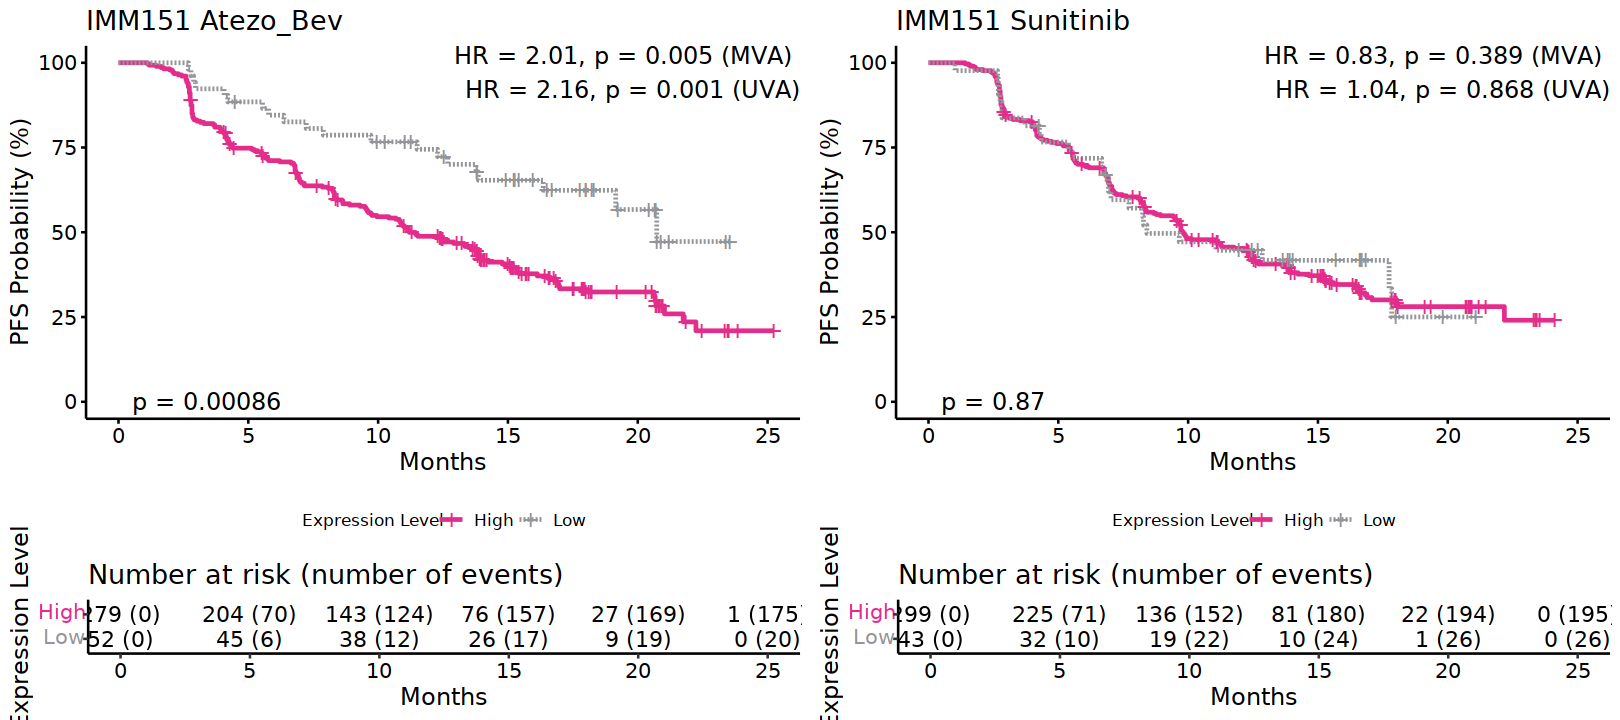

In [42]:
library(cowplot)
options(repr.plot.width=13.5, repr.plot.height=6)
plot_grid(io_labeled, tki_labeled, io$table, tki$table, label_size = 12, nrow = 2,rel_heights= c(4,1.2))

ggsave("../Figures/Figure4/Figure4B_imm151_curves.pdf", width = 13.5, height = 6)

### JAV101

In [43]:
options(repr.plot.width=10.5, repr.plot.height=9)

avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

In [44]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib = subset(clin_jav101_full, Arm == "Sunitinib")

sunitinib = subset(sunitinib, ORR %in% c("CR","PD","PR","SD"))
sunitinib = mutate(sunitinib, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(sunitinib$Benefit)

sunitinib = mutate(sunitinib, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
182 161 

### First, find optimal cutoff for Krishna_CD8A_Tissue_resident. Then within that subset, binarize myeloid IFNG score

cutpoint  statistic
Krishna_CD8A_Tissue_resident -2.855867 3.710634

$Krishna_CD8A_Tissue_resident


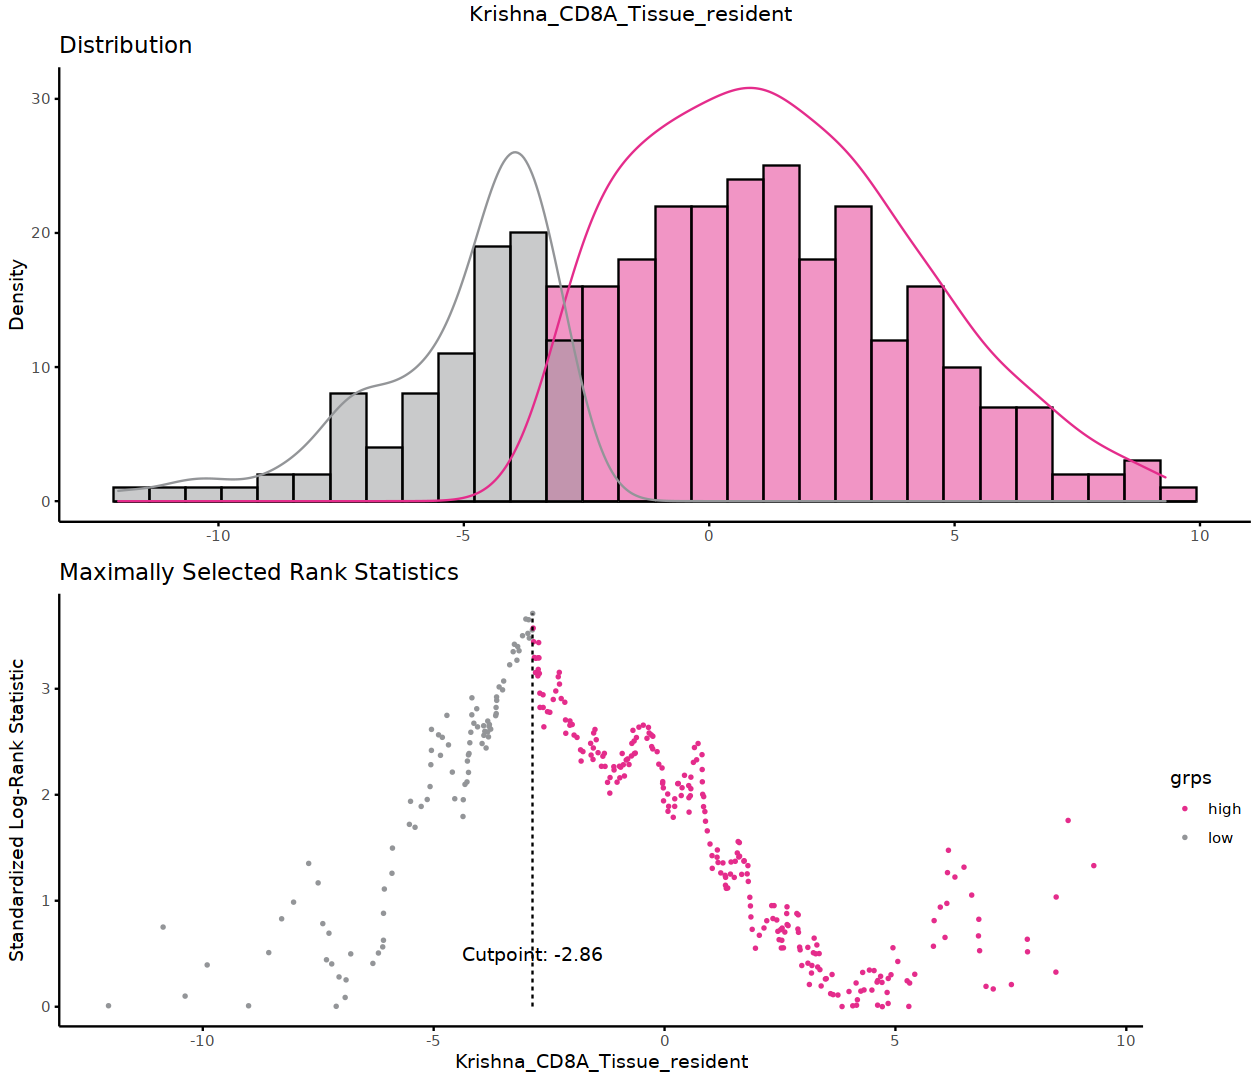

In [45]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_cd8 <- surv_cutpoint(avel_axit, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("Krishna_CD8A_Tissue_resident"))
summary(res.cut_cd8)

plot(res.cut_cd8, "Krishna_CD8A_Tissue_resident", palette = c("#e42c8b","#939598"))

In [46]:
res.cut_cd8$cutpoint$cutpoint

[1] -2.855867

In [47]:
avel_axit_topcd8 = subset(avel_axit, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(avel_axit_topcd8)

[1]   245 40348

In [48]:
sunitinib_topcd8 = subset(sunitinib, Krishna_CD8A_Tissue_resident > res.cut_cd8$cutpoint$cutpoint)
dim(sunitinib_topcd8)

[1]   275 40348

cutpoint  statistic
manuscript_IFNG_myeloid -1.283223 2.767251

$manuscript_IFNG_myeloid


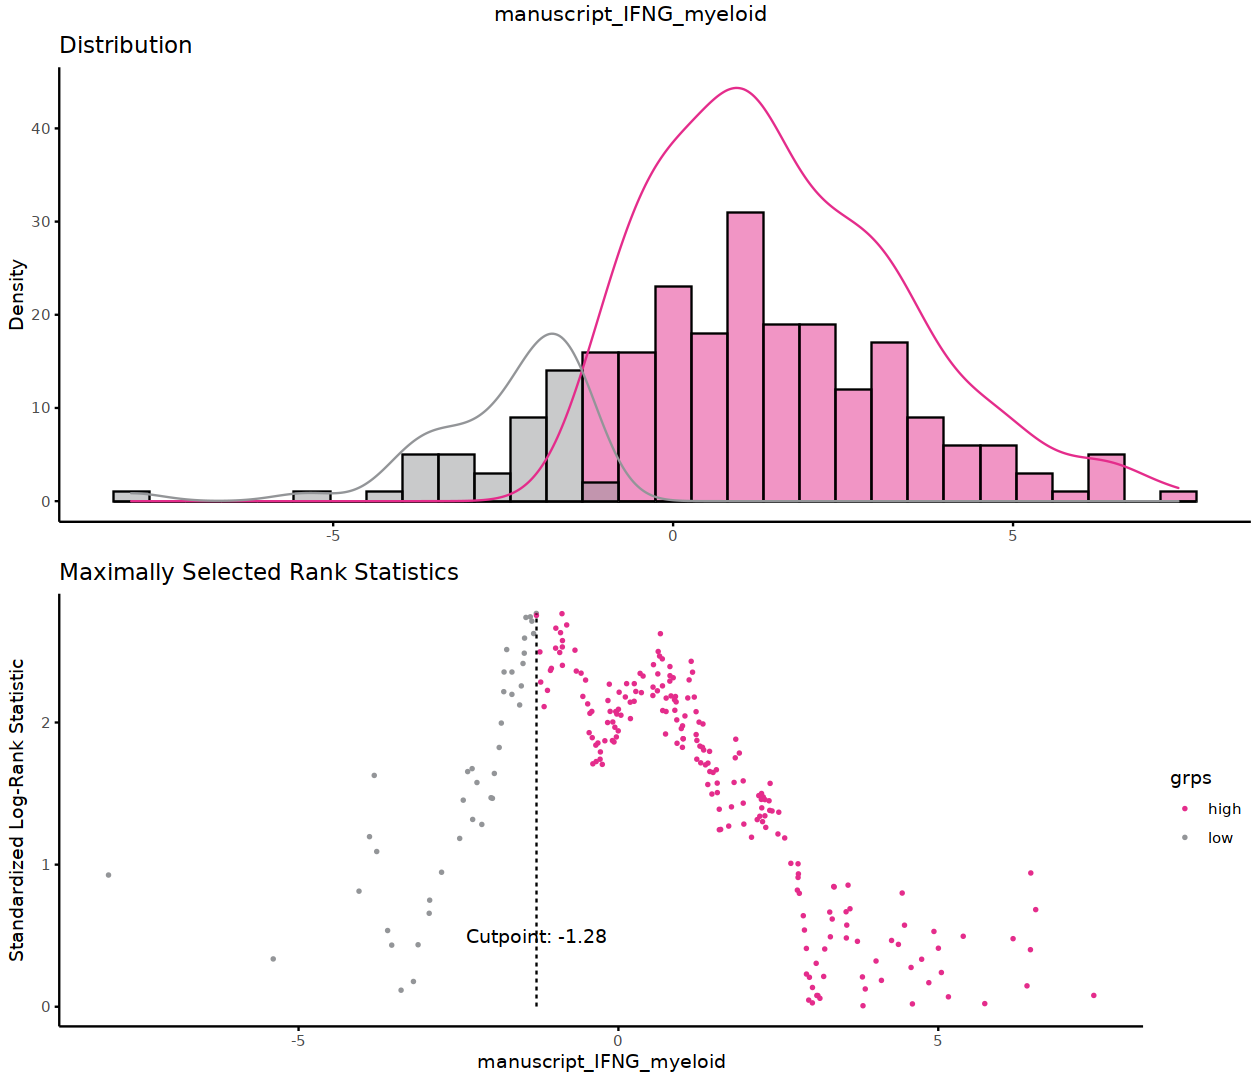

In [49]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cut_myeloid <- surv_cutpoint(avel_axit_topcd8, time = "PFS", event = "PFS_CNSR",minprop = 0,
   variables = c("manuscript_IFNG_myeloid"))
summary(res.cut_myeloid)

plot(res.cut_myeloid, "manuscript_IFNG_myeloid", palette = c("#e42c8b","#939598"))

In [50]:
res.cat <- surv_categorize(res.cut_myeloid)
head(res.cat)
dim(res.cat)
table(res.cat$manuscript_IFNG_myeloid)

PFS       PFS_CNSR manuscript_IFNG_myeloid
10011001_6203185783  1.379877 1        low                    
10011015_6204820848  2.891170 1        high                   
10011017_6204067222 18.135524 0        high                   
10011020_6204820845  1.412731 1        low                    
10011021_6204820844  3.318275 0        low                    
10011027_6204067225  2.891170 1        high

[1] 245   3


high  low 
 204   41 

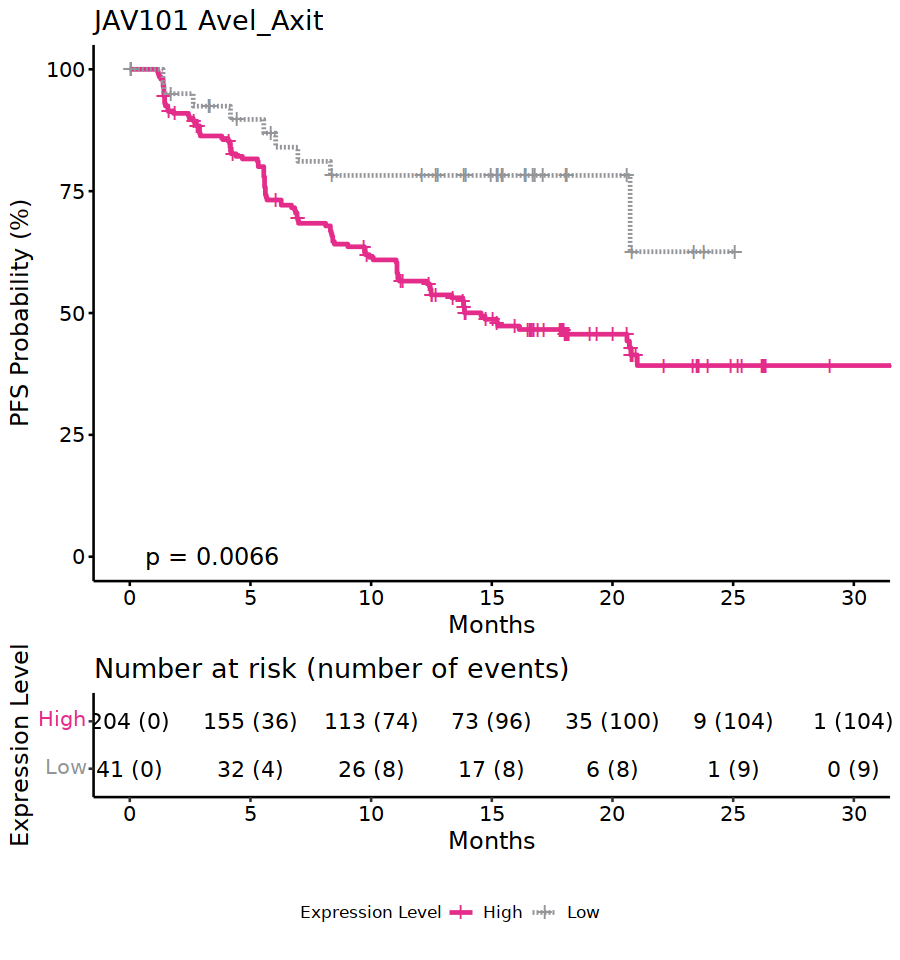

In [51]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid, data = res.cat)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T,palette = c("#e42c8b","#939598"))
io = ggsurvplot(fit,title = "JAV101 Avel_Axit",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low"),
                break.x.by = 5
    )
io

In [52]:
sunitinib_topcd8 = mutate(sunitinib_topcd8, manuscript_IFNG_myeloid_group = ifelse(manuscript_IFNG_myeloid > res.cut_myeloid$cutpoint$cutpoint, "high","low"))
sunitinib_topcd8$manuscript_IFNG_myeloid_group = factor(sunitinib_topcd8$manuscript_IFNG_myeloid_group, levels = c("high","low"))
table(sunitinib_topcd8$manuscript_IFNG_myeloid_group)


high  low 
 235   40 

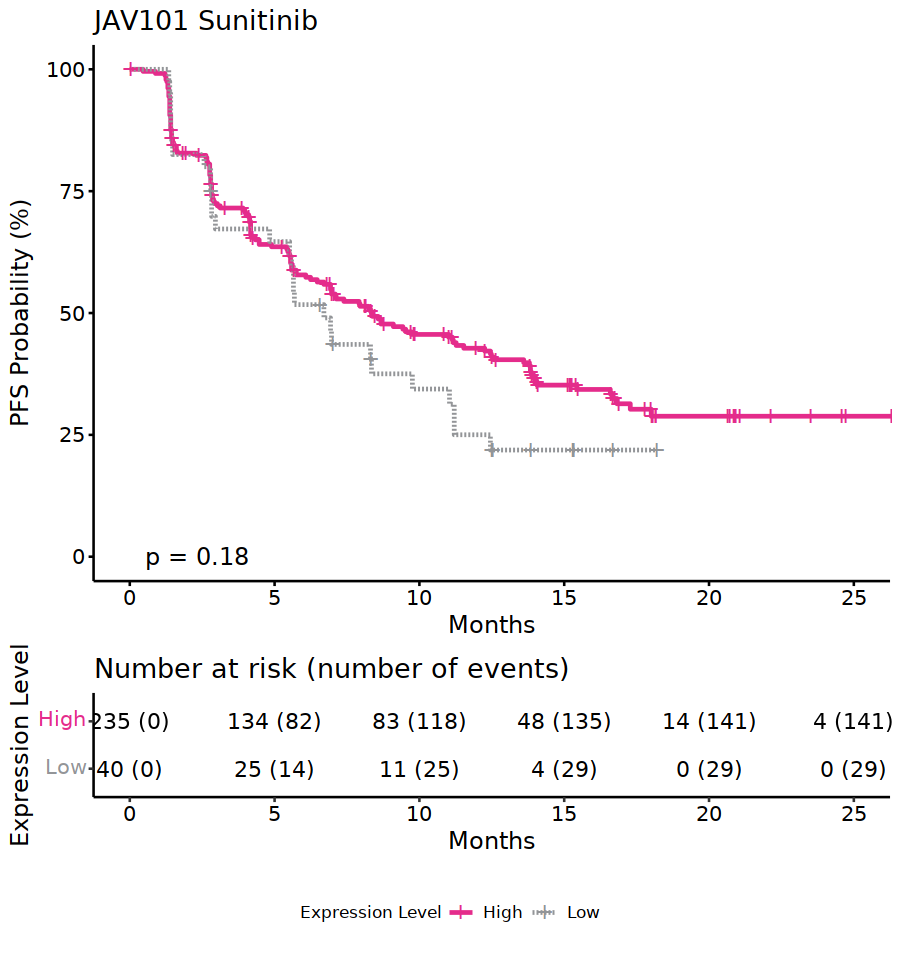

In [53]:
options(repr.plot.width=7.5, repr.plot.height=8)

fit <- survfit(Surv(PFS, PFS_CNSR) ~ manuscript_IFNG_myeloid_group, data = sunitinib_topcd8)
#ggsurvplot(fit, risk.table = TRUE, conf.int = F,pval = T, palette = c("#e42c8b","#939598"))

tki = ggsurvplot(fit,title = "JAV101 Sunitinib",
           fun = "pct",
           risk.table = "nrisk_cumevents",
           size = 1,
           linetype = "strata",
           ylab= "PFS Probability (%)",
           xlab= "Months",
           pval = TRUE,
           palette = c("#e42c8b","#939598"),
           legend = "bottom",
           legend.title = "Expression Level",
           legend.labs = c("High",
                           "Low")
    )
tki

### Let's check if this binarized IFNG myeloid score is significantly associated with worse PFS under a multivariate Cox

In [54]:
setequal(row.names(res.cat), row.names(avel_axit_topcd8))

[1] TRUE

In [55]:
avel_axit_topcd8$manuscript_IFNG_myeloid_group = res.cat$manuscript_IFNG_myeloid
avel_axit_topcd8$manuscript_IFNG_myeloid_group = factor(avel_axit_topcd8$manuscript_IFNG_myeloid_group, levels = c("low","high"))
table(avel_axit_topcd8$manuscript_IFNG_myeloid_group)


 low high 
  41  204 

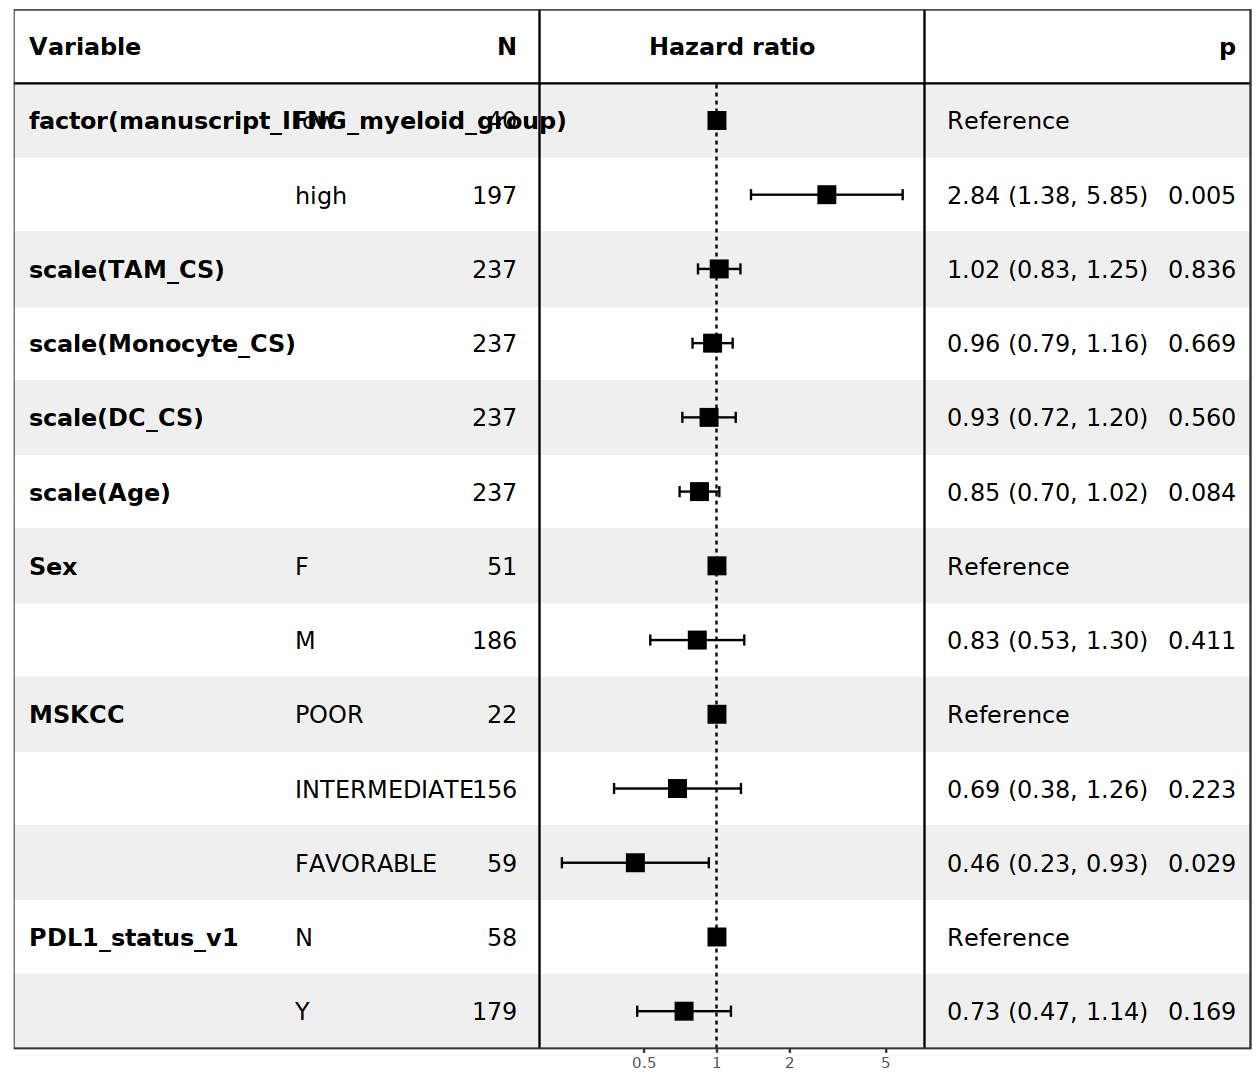

In [56]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

### Sunitinib arm

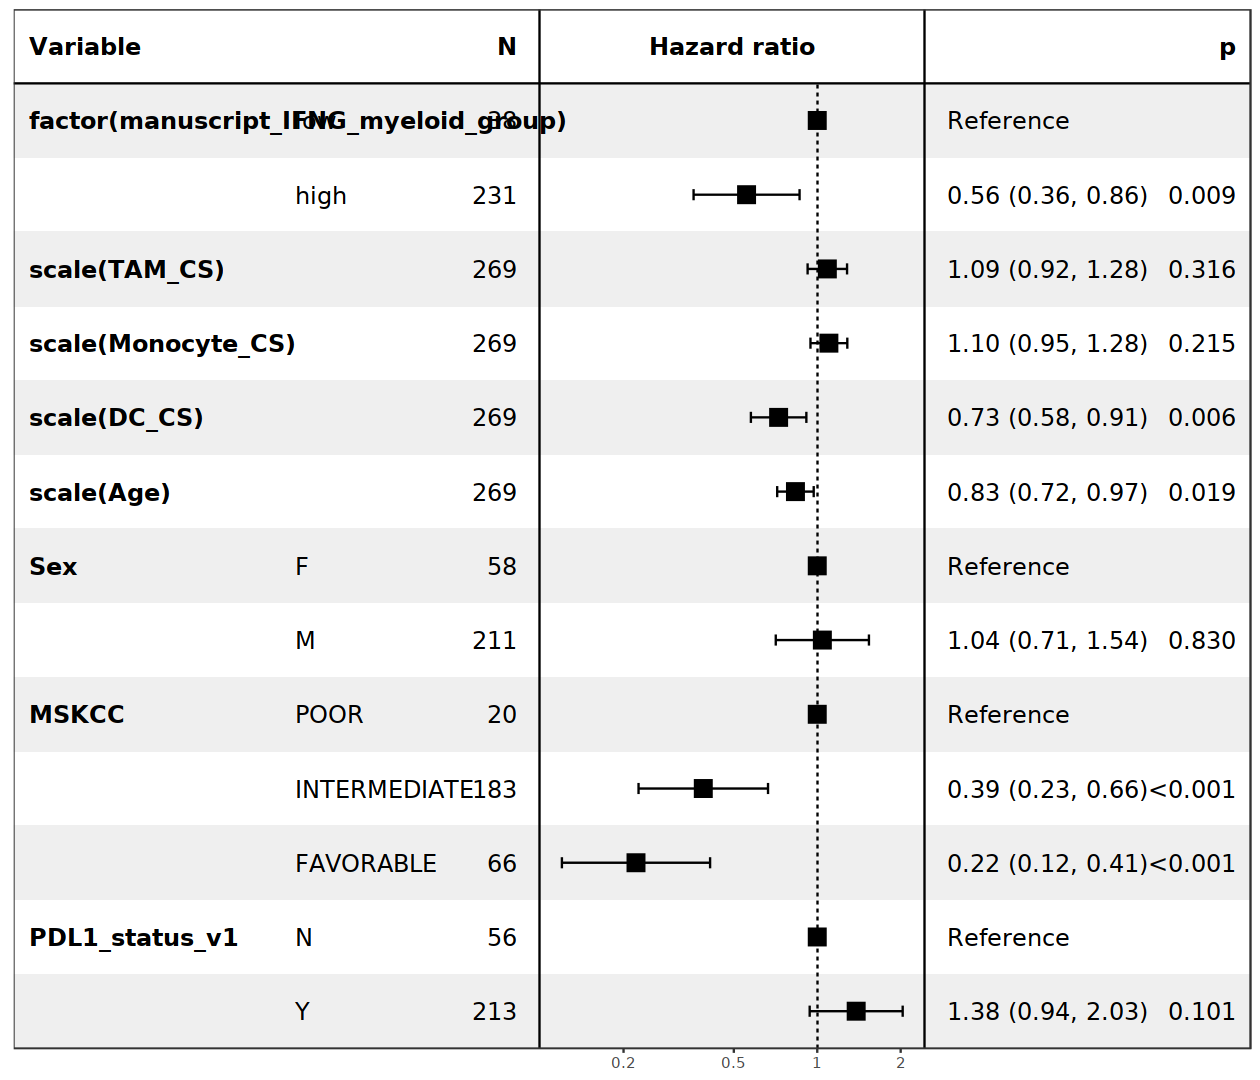

In [57]:
options(repr.plot.width=10.5, repr.plot.height=9)

sunitinib_topcd8$manuscript_IFNG_myeloid_group = relevel(sunitinib_topcd8$manuscript_IFNG_myeloid_group, ref = "low")

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib_topcd8)
forest_model(res.cox, panels,recalculate_width = F)

### Plot IO+VEGF and VEGF arms together with hazard ratios and p-values for multi and univariate analyses and export. For the multivariate analysis, we will use only myeloid IFNG signalling, myeloid cibersort fractions, and clinicopathological variables.

In [58]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit_topcd8)
summary(res.cox)$coefficients


jav101_avel_axit_topcd8_MVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(jav101_avel_axit_topcd8_MVA) = c("HR","p")
jav101_avel_axit_topcd8_MVA

coef        exp(coef) se(coef)  
factor(manuscript_IFNG_myeloid_group)high  1.04497082 2.8433156 0.36800075
scale(TAM_CS)                              0.02130089 1.0215294 0.10299676
scale(Monocyte_CS)                        -0.04166421 0.9591918 0.09739610
scale(DC_CS)                              -0.07548604 0.9272927 0.12952822
scale(Age)                                -0.16645460 0.8466613 0.09642086
SexM                                      -0.18732470 0.8291745 0.22808961
MSKCCINTERMEDIATE                         -0.37546103 0.6869725 0.30783093
MSKCCFAVORABLE                            -0.77609590 0.4601992 0.35649367
PDL1_status_v1Y                           -0.31281659 0.7313840 0.22737751
                                          z          Pr(>|z|)   
factor(manuscript_IFNG_myeloid_group)high  2.8395889 0.004517171
scale(TAM_CS)                              0.2068113 0.836157268
scale(Monocyte_CS)                        -0.4277810 0.668810553
scale(DC_CS)                              -0.5827767 0.560043601
scale(Age)                                -1.7263340 0.084287342
SexM                                      -0.8212768 0.411488632
MSKCCINTERMEDIATE                         -1.2196989 0.222579056
MSKCCFAVORABLE                            -2.1770258 0.029478644
PDL1_status_v1Y                           -1.3757587 0.168896348

HR           p 
2.843315559 0.004517171

In [59]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group), data = avel_axit_topcd8)
summary(res.cox)$coefficients


jav101_avel_axit_topcd8_UVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(jav101_avel_axit_topcd8_UVA) = c("HR","p")
jav101_avel_axit_topcd8_UVA

coef      exp(coef) se(coef) 
factor(manuscript_IFNG_myeloid_group)high 0.9103429 2.485175  0.3475864
                                          z        Pr(>|z|)   
factor(manuscript_IFNG_myeloid_group)high 2.619041 0.008817739

HR           p 
2.485174611 0.008817739

In [60]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = sunitinib_topcd8)
summary(res.cox)$coefficients


jav101_sunitinib_topcd8_MVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(jav101_sunitinib_topcd8_MVA) = c("HR","p")
jav101_sunitinib_topcd8_MVA

coef        exp(coef) se(coef)  
factor(manuscript_IFNG_myeloid_group)high -0.58723564 0.5558618 0.22463464
scale(TAM_CS)                              0.08379286 1.0874036 0.08362369
scale(Monocyte_CS)                         0.09672452 1.1015569 0.07807956
scale(DC_CS)                              -0.32092424 0.7254782 0.11756926
scale(Age)                                -0.18110979 0.8343437 0.07740251
SexM                                       0.04242331 1.0433360 0.19749852
MSKCCINTERMEDIATE                         -0.94688864 0.3879462 0.27445705
MSKCCFAVORABLE                            -1.50595532 0.2218053 0.31410495
PDL1_status_v1Y                            0.32347301 1.3819189 0.19713138
                                          z          Pr(>|z|)    
factor(manuscript_IFNG_myeloid_group)high -2.6141812 8.944160e-03
scale(TAM_CS)                              1.0020230 3.163325e-01
scale(Monocyte_CS)                         1.2387943 2.154217e-01
scale(DC_CS)                              -2.7296612 6.339944e-03
scale(Age)                                -2.3398439 1.929180e-02
SexM                                       0.2148032 8.299208e-01
MSKCCINTERMEDIATE                         -3.4500431 5.604971e-04
MSKCCFAVORABLE                            -4.7944336 1.631351e-06
PDL1_status_v1Y                            1.6409006 1.008180e-01

HR          p 
0.55586177 0.00894416

In [61]:
options(repr.plot.width=10.5, repr.plot.height=9)

res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ factor(manuscript_IFNG_myeloid_group), data = sunitinib_topcd8)
summary(res.cox)$coefficients


jav101_sunitinib_topcd8_UVA = c(summary(res.cox)$coefficients["factor(manuscript_IFNG_myeloid_group)high",c("exp(coef)","Pr(>|z|)")])
names(jav101_sunitinib_topcd8_UVA) = c("HR","p")
jav101_sunitinib_topcd8_UVA

coef       exp(coef) se(coef)
factor(manuscript_IFNG_myeloid_group)high -0.2774124 0.7577419 0.204768
                                          z         Pr(>|z|) 
factor(manuscript_IFNG_myeloid_group)high -1.354764 0.1754926

HR         p 
0.7577419 0.1754926

In [62]:
label_MVA_io = paste("HR = ",round(jav101_avel_axit_topcd8_MVA["HR"],2), ", p = ", round(jav101_avel_axit_topcd8_MVA["p"],3), " (MVA)",sep = "")
label_UVA_io = paste("HR = ",round(jav101_avel_axit_topcd8_UVA["HR"],2), ", p = ", round(jav101_avel_axit_topcd8_UVA["p"],3), " (UVA)",sep = "")
label_MVA_io
label_UVA_io

[1] "HR = 2.84, p = 0.005 (MVA)"

[1] "HR = 2.49, p = 0.009 (UVA)"

In [63]:
label_MVA_tki = paste("HR = ",round(jav101_sunitinib_topcd8_MVA["HR"],2), ", p = ", round(jav101_sunitinib_topcd8_MVA["p"],3), " (MVA)",sep = "")
label_UVA_tki = paste("HR = ",round(jav101_sunitinib_topcd8_UVA["HR"],2), ", p = ", round(jav101_sunitinib_topcd8_UVA["p"],3), " (UVA)",sep = "")
label_MVA_tki
label_UVA_tki

[1] "HR = 0.56, p = 0.009 (MVA)"

[1] "HR = 0.76, p = 0.175 (UVA)"

In [64]:
io_labeled = io$plot + ggplot2::annotate(
    "text",
    x = Inf, y = Inf,
    vjust = 1, hjust = 1,
    label = paste(label_MVA_io, " \n ",label_UVA_io, sep = ""),
    size = 5
  )

In [65]:
tki_labeled = tki$plot + ggplot2::annotate(
    "text",
    x = Inf, y = Inf,
    vjust = 1, hjust = 1,
    label = paste(label_MVA_tki, " \n ",label_UVA_tki, sep = ""),
    size = 5
  )

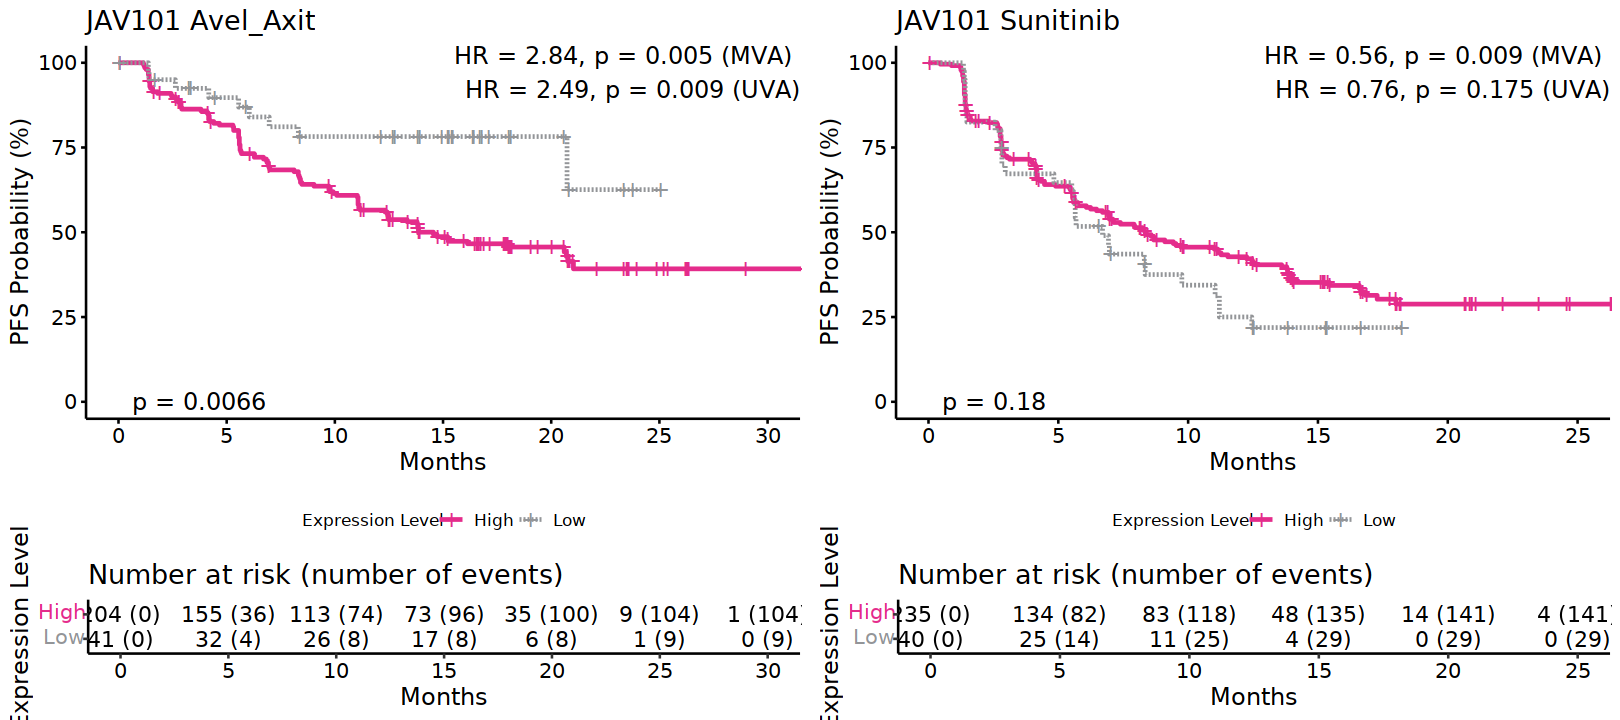

In [66]:
library(cowplot)
options(repr.plot.width=13.5, repr.plot.height=6)
plot_grid(io_labeled, tki_labeled, io$table, tki$table, label_size = 12, nrow = 2,rel_heights= c(4,1.2))

ggsave("../Figures/Figure4/Figure4D_jav101_curves.pdf", width = 13.5, height = 6)

### Figure 4E. Scatter plots showing hazard ratios and odds ratios for all myeloid signatures in models for PFS and CB/NCB in IMM151 and JAV101 <a name="3"></a>

### Identify all myeloid signatures of interest (mcdermott, braun, krishna, kinget etc)

In [67]:
grep("myeloid",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("tam",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("monocyte",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("dc",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("macrophage",names(ISG_sigs),ignore.case=TRUE,value=TRUE)
grep("mac",names(ISG_sigs),ignore.case=TRUE,value=TRUE)

[1] "manuscript_IFN1_myeloid"        "manuscript_IFNG_myeloid"       
[3] "manuscript_myeloid_combined"    "immotion.myeloid"              
[5] "MCDERMOTT_MYELOID_INFLAMMATION"

[1] "TAM_NISG"                  "TAMsurr_score"            
 [3] "TAMsurr_TcClassII_ratio"   "Krishna_TAM_ISGInt"       
 [5] "Krishna_TAM_HLAhi"         "Krishna_TAM_ISGhi"        
 [7] "Krishna_TAM_HLAint"        "Krishna_TAM_Intersect"    
 [9] "Krishna_TAM_HLAint_Unique" "Krishna_TAM_HLAhi_Unique" 
[11] "Krishna_TAM_ISGInt_Unique" "Krishna_TAM_ISGhi_Unique"

[1] "Monocyte_NISG"

[1] "DC_NISG" "aDC"     "DC"      "iDC"     "pDC"

[1] "Macrophages"

[1] "Macrophages"

In [68]:
ISG_sigs$immotion.myeloid

[1] "IL6"   "CXCL1" "CXCL2" "CXCL3" "CXCL8" "PTGS2"

In [69]:
ISG_sigs$MCDERMOTT_MYELOID_INFLAMMATION

[1] "IL6"   "CXCL1" "CXCL2" "CXCL3" "CXCL8" "PTGS2"

In [70]:
myeloid_sigs = c("tLHP_signature","MCDERMOTT_MYELOID_INFLAMMATION","Krishna_TAM_ISGInt","Krishna_TAM_ISGhi","Krishna_TAM_HLAint","Krishna_TAM_HLAhi","TAM_NISG","Monocyte_NISG","DC_NISG","TAMsurr_score","manuscript_IFNG_myeloid")

### Run Cox models for PFS in IMM151 and JAV101 using these signatures. We also calculate a VIF using a regular linear model for CYT, as the vif function is not suitable for use on Cox models

In [71]:
clin_imm151_full$PDL1_IHC = relevel(factor(clin_imm151_full$PDL1_IHC), ref = "PDL1-")
atezo_bev = subset(clin_imm151_full, ARM == "atezo_bev")

atezo_bev = subset(atezo_bev, OBJECTIVE_RESPONSE %in% c("CR","PD","PR","SD"))
atezo_bev = mutate(atezo_bev, Benefit = ifelse(OBJECTIVE_RESPONSE == "CR","CB",ifelse(OBJECTIVE_RESPONSE == "PR","CB",ifelse(OBJECTIVE_RESPONSE == "PD","NCB",ifelse(OBJECTIVE_RESPONSE == "SD" & PFS_MONTHS >= 6,"CB","NCB")))))
table(atezo_bev$Benefit)

atezo_bev = mutate(atezo_bev, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
263 117 

In [72]:
imm151_res = list()
for (i in 1:length(myeloid_sigs)){
    atezo_bev2 = atezo_bev
    atezo_bev2$test = as.numeric(atezo_bev2[,myeloid_sigs[i]])
    res.cox <- coxph(Surv(PFS_MONTHS, PFS_CENSOR) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev2)
    summary_res = summary(res.cox)$coefficients
    
    pretend.lm <- lm(scale(CYT) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, data = atezo_bev2)
    vif_res_cox = vif(pretend.lm)

    
    myl_summary = summary_res["scale(test)",]
    
    final_result = c(myl_summary,max(vif_res_cox[,"GVIF"]))
    
    imm151_res[[i]] = final_result
    
}

names(imm151_res) = myeloid_sigs
imm151_res_df = data.frame(t(as.data.frame(imm151_res)))
colnames(imm151_res_df) = c("coef",'HR',"se_coef","z","pval","Cox_dummy_lm_maxVIF")
colnames(imm151_res_df) = paste("imm151_",colnames(imm151_res_df),sep = "")
imm151_res_df[order(imm151_res_df$imm151_HR, decreasing = T),]

imm151_coef imm151_HR imm151_se_coef imm151_z
Krishna_TAM_ISGInt             0.53704208  1.710939  0.19532542     2.749474
manuscript_IFNG_myeloid        0.46199525  1.587238  0.14022545     3.294660
Krishna_TAM_HLAint             0.42144181  1.524158  0.12416699     3.394153
Krishna_TAM_HLAhi              0.36424363  1.439425  0.12002371     3.034764
Krishna_TAM_ISGhi              0.30298002  1.353887  0.10529532     2.877431
TAMsurr_score                  0.26213207  1.299698  0.09512578     2.755636
DC_NISG                        0.20656480  1.229447  0.11020380     1.874389
TAM_NISG                       0.20639292  1.229236  0.10835419     1.904799
Monocyte_NISG                  0.19993057  1.221318  0.10364186     1.929052
tLHP_signature                 0.17177217  1.187407  0.09736504     1.764208
MCDERMOTT_MYELOID_INFLAMMATION 0.08525754  1.088997  0.07507193     1.135678
                               imm151_pval  imm151_Cox_dummy_lm_maxVIF
Krishna_TAM_ISGInt             0.0059691076 11.707233                 
manuscript_IFNG_myeloid        0.0009854068  6.930480                 
Krishna_TAM_HLAint             0.0006884112  6.128419                 
Krishna_TAM_HLAhi              0.0024072411  6.795775                 
Krishna_TAM_ISGhi              0.0040092769  5.610823                 
TAMsurr_score                  0.0058578074  5.102090                 
DC_NISG                        0.0608768220  6.412710                 
TAM_NISG                       0.0568062381  5.888877                 
Monocyte_NISG                  0.0537243608  6.426619                 
tLHP_signature                 0.0776969940  6.233613                 
MCDERMOTT_MYELOID_INFLAMMATION 0.2560913722  4.723795

In [73]:
avel_axit = subset(clin_jav101_full, Arm == "Avelumab + Axitinib")

avel_axit = subset(avel_axit, ORR %in% c("CR","PD","PR","SD"))
avel_axit = mutate(avel_axit, Benefit = ifelse(ORR == "CR","CB",ifelse(ORR == "PR","CB",ifelse(ORR == "PD","NCB",ifelse(ORR == "SD" & PFS >= 6,"CB","NCB")))))
table(avel_axit$Benefit)

avel_axit = mutate(avel_axit, Benefit_Binary_Num = ifelse(Benefit == "CB",1,0))


 CB NCB 
239  96 

In [74]:
jav101_res = list()
for (i in 1:length(myeloid_sigs)){
    avel_axit2 = avel_axit
    avel_axit2$test = as.numeric(avel_axit2[,myeloid_sigs[i]])
    res.cox <- coxph(Surv(PFS, PFS_CNSR) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit2)
    summary_res = summary(res.cox)$coefficients
    
    pretend.lm <- lm(scale(CYT) ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, data = avel_axit2)
    vif_res_cox = vif(pretend.lm)

    
    myl_summary = summary_res["scale(test)",]
    
    final_result = c(myl_summary,max(vif_res_cox[,"GVIF"]))
    
    jav101_res[[i]] = final_result
    
}

names(jav101_res) = myeloid_sigs
jav101_res_df = data.frame(t(as.data.frame(jav101_res)))
colnames(jav101_res_df) = c("coef",'HR',"se_coef","z","pval","Cox_dummy_lm_maxVIF")
colnames(jav101_res_df) = paste("jav101_",colnames(jav101_res_df),sep = "")
jav101_res_df[order(jav101_res_df$jav101_HR, decreasing = T),]

jav101_coef jav101_HR jav101_se_coef jav101_z 
Krishna_TAM_ISGInt             0.55994245  1.750572  0.2525826      2.2168685
manuscript_IFNG_myeloid        0.40671045  1.501869  0.1892002      2.1496301
Krishna_TAM_HLAint             0.34748587  1.415504  0.1648950      2.1073160
Krishna_TAM_HLAhi              0.34055858  1.405733  0.1622831      2.0985457
TAMsurr_score                  0.26190468  1.299403  0.1289354      2.0312860
MCDERMOTT_MYELOID_INFLAMMATION 0.21846073  1.244160  0.1020675      2.1403545
TAM_NISG                       0.19238186  1.212133  0.1309761      1.4688320
DC_NISG                        0.14815787  1.159696  0.1370669      1.0809166
Monocyte_NISG                  0.14748372  1.158914  0.1235944      1.1932876
Krishna_TAM_ISGhi              0.11758859  1.124781  0.1270850      0.9252750
tLHP_signature                 0.06717875  1.069487  0.1150711      0.5838019
                               jav101_pval jav101_Cox_dummy_lm_maxVIF
Krishna_TAM_ISGInt             0.02663208  11.533021                 
manuscript_IFNG_myeloid        0.03158448   7.464799                 
Krishna_TAM_HLAint             0.03509020   5.512972                 
Krishna_TAM_HLAhi              0.03585697   5.873729                 
TAMsurr_score                  0.04222599   4.315479                 
MCDERMOTT_MYELOID_INFLAMMATION 0.03232613   3.859907                 
TAM_NISG                       0.14187836   5.994065                 
DC_NISG                        0.27973422   6.226459                 
Monocyte_NISG                  0.23275675   6.276369                 
Krishna_TAM_ISGhi              0.35482287   4.615065                 
tLHP_signature                 0.55935357   5.495621

### We'll only consider signatures where the model covariates all had VIF < 10

In [75]:
imm151_res_df = subset(imm151_res_df, imm151_Cox_dummy_lm_maxVIF < 10)
jav101_res_df = subset(jav101_res_df, jav101_Cox_dummy_lm_maxVIF < 10)
setequal(row.names(imm151_res_df), row.names(jav101_res_df))

scatter_df = cbind(imm151_res_df[,c("imm151_HR","imm151_pval")],jav101_res_df[,c("jav101_HR","jav101_pval")])
scatter_df

[1] TRUE

imm151_HR imm151_pval  jav101_HR jav101_pval
tLHP_signature                 1.187407  0.0776969940 1.069487  0.55935357 
MCDERMOTT_MYELOID_INFLAMMATION 1.088997  0.2560913722 1.244160  0.03232613 
Krishna_TAM_ISGhi              1.353887  0.0040092769 1.124781  0.35482287 
Krishna_TAM_HLAint             1.524158  0.0006884112 1.415504  0.03509020 
Krishna_TAM_HLAhi              1.439425  0.0024072411 1.405733  0.03585697 
TAM_NISG                       1.229236  0.0568062381 1.212133  0.14187836 
Monocyte_NISG                  1.221318  0.0537243608 1.158914  0.23275675 
DC_NISG                        1.229447  0.0608768220 1.159696  0.27973422 
TAMsurr_score                  1.299698  0.0058578074 1.299403  0.04222599 
manuscript_IFNG_myeloid        1.587238  0.0009854068 1.501869  0.03158448

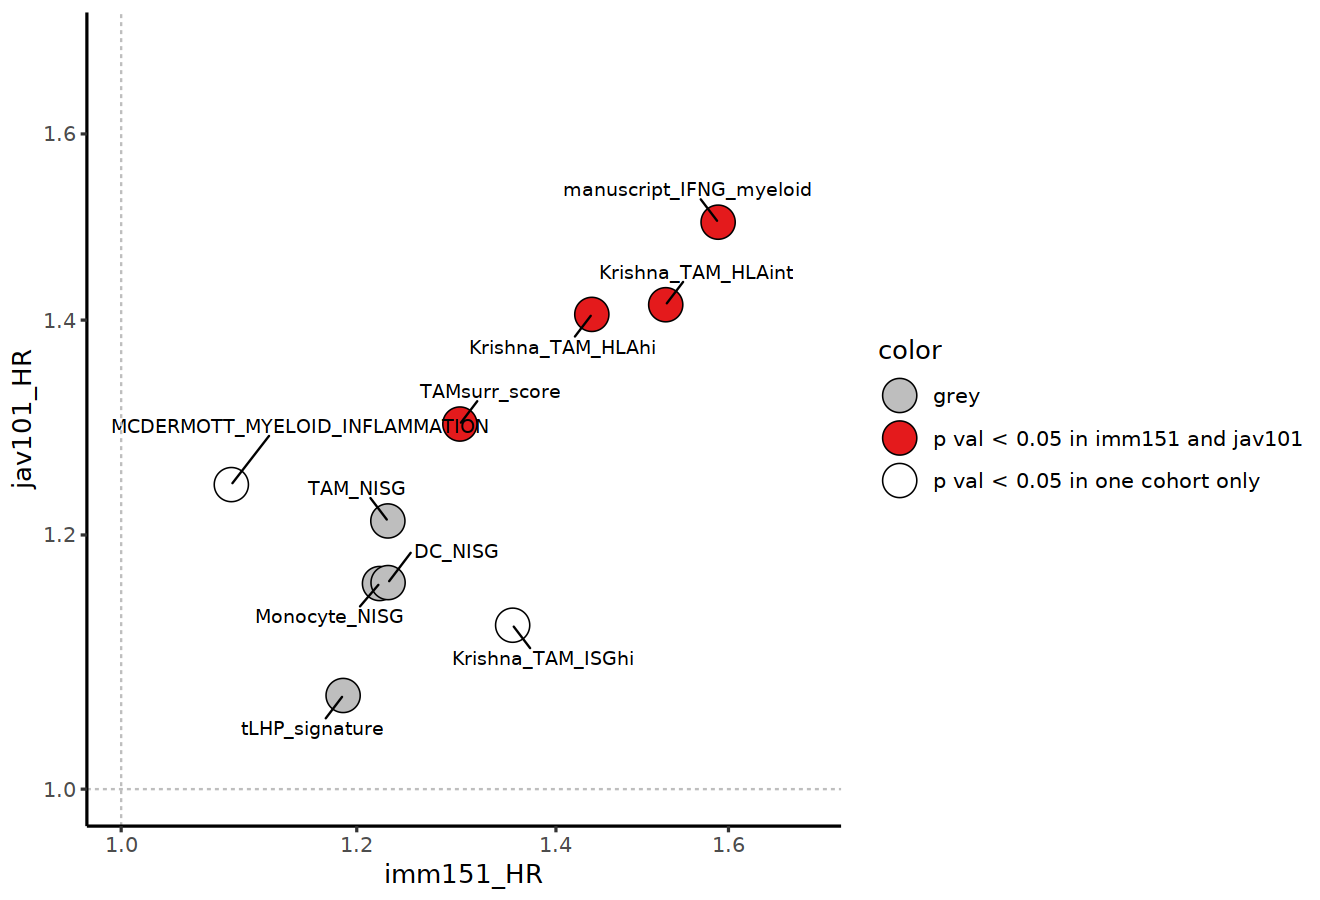

In [76]:
scatter_df = mutate(scatter_df, color = ifelse(imm151_pval < 0.05 & jav101_pval < 0.05, "p val < 0.05 in imm151 and jav101",ifelse(imm151_pval < 0.05 | jav101_pval < 0.05, "p val < 0.05 in one cohort only","grey")))
scatter_df$label = row.names(scatter_df)

library(ggrepel)
options(repr.plot.width=11, repr.plot.height=7.5)
ggplot(scatter_df, aes(x=imm151_HR, y=jav101_HR, fill = color, label = label)) +
  geom_point(size=9, shape = 21) + theme_classic(base_size = 15) + scale_fill_manual(values = c("grey","#e41a1c","white")) + geom_text_repel(box.padding = 1) +
geom_vline(xintercept = 1, color = "grey",linetype = "dashed") + 
geom_hline(yintercept = 1, color = "grey",linetype = "dashed") +
coord_trans(x = c("log"), y = c("log"),xlim = c(1,1.7),ylim = c(1,1.7))

ggsave("../Figures/Figure4/Figure4E_scatter_myeloid_HRs.pdf", width = 11, height = 7.5)

### Run logistic regression for PFS in IMM151 and JAV101 using these signatures

In [77]:
imm151_res = list()
for (i in 1:length(myeloid_sigs)){
    atezo_bev2 = atezo_bev
    atezo_bev2$test = as.numeric(atezo_bev2[,myeloid_sigs[i]])
    mylogit <- glm(Benefit_Binary_Num ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(AGE) + SEX + MSKCC_RISK_SCORE + PDL1_IHC, family = "binomial", data = atezo_bev2)
    summary_logit = summary(mylogit)$coefficients
    
    vif_res_logit = vif(mylogit)

    
    myl_summary = summary_logit["scale(test)",]
    odds_ratio = exp(myl_summary["Estimate"])
    
    final_result = c(myl_summary,odds_ratio,max(vif_res_logit[,"GVIF"]))
    
    imm151_res[[i]] = final_result
    
}

names(imm151_res) = myeloid_sigs
imm151_res_df = data.frame(t(as.data.frame(imm151_res)))
colnames(imm151_res_df) = c("Est",'StdError',"z","pval","OR","logit_maxVIF")
colnames(imm151_res_df) = paste("imm151_",colnames(imm151_res_df),sep = "")
imm151_res_df[order(imm151_res_df$imm151_OR, decreasing = F),]

imm151_Est  imm151_StdError imm151_z  
Krishna_TAM_ISGInt             -0.81603574 0.3359704       -2.4288918
Krishna_TAM_HLAint             -0.66197127 0.2189662       -3.0231667
Krishna_TAM_HLAhi              -0.58476487 0.2155151       -2.7133357
manuscript_IFNG_myeloid        -0.57555898 0.2445652       -2.3533973
DC_NISG                        -0.42979698 0.2005781       -2.1427915
Krishna_TAM_ISGhi              -0.38194982 0.1878685       -2.0330696
TAM_NISG                       -0.37331594 0.1899849       -1.9649773
TAMsurr_score                  -0.26227597 0.1681434       -1.5598350
Monocyte_NISG                  -0.22601091 0.1847731       -1.2231810
MCDERMOTT_MYELOID_INFLAMMATION -0.20383460 0.1335349       -1.5264518
tLHP_signature                 -0.07627089 0.1709765       -0.4460899
                               imm151_pval imm151_OR imm151_logit_maxVIF
Krishna_TAM_ISGInt             0.015145053 0.4421811 11.878495          
Krishna_TAM_HLAint             0.002501444 0.5158335  6.231962          
Krishna_TAM_HLAhi              0.006660959 0.5572369  7.014145          
manuscript_IFNG_myeloid        0.018602744 0.5623904  7.044035          
DC_NISG                        0.032129842 0.6506412  6.526023          
Krishna_TAM_ISGhi              0.042045495 0.6825293  5.724907          
TAM_NISG                       0.049416869 0.6884477  5.930136          
TAMsurr_score                  0.118798868 0.7692987  5.025800          
Monocyte_NISG                  0.221261355 0.7977094  6.533763          
MCDERMOTT_MYELOID_INFLAMMATION 0.126897390 0.8155973  4.647079          
tLHP_signature                 0.655532288 0.9265652  6.339455

In [78]:
jav101_res = list()
for (i in 1:length(myeloid_sigs)){
    avel_axit2 = avel_axit
    avel_axit2$test = as.numeric(avel_axit2[,myeloid_sigs[i]])
    mylogit <- glm(Benefit_Binary_Num ~ scale(test) + scale(TAM_CS) + scale(Monocyte_CS) + scale(DC_CS) + scale(Krishna_CD8A_Tissue_resident) + scale(CD8_CS) + scale(manuscript_IFNG_tumor)  + scale(Tumor_CS) + scale(Fibroblast_CS) + scale(Age) + Sex + MSKCC + PDL1_status_v1, family = "binomial", data = avel_axit2)
    summary_logit = summary(mylogit)$coefficients
    
    vif_res_logit = vif(mylogit)
    
    myl_summary = summary_logit["scale(test)",]
    odds_ratio = exp(myl_summary["Estimate"])
    
    final_result = c(myl_summary,odds_ratio,max(vif_res_logit[,"GVIF"]))
    
    jav101_res[[i]] = final_result
    
}

names(jav101_res) = myeloid_sigs
jav101_res_df = data.frame(t(as.data.frame(jav101_res)))
colnames(jav101_res_df) = c("Est",'StdError',"z","pval","OR","logit_maxVIF")
colnames(jav101_res_df) = paste("jav101_",colnames(jav101_res_df),sep = "")
jav101_res_df[order(jav101_res_df$jav101_OR, decreasing = F),]

jav101_Est  jav101_StdError jav101_z   
TAMsurr_score                  -0.70730931 0.2253988       -3.13803431
manuscript_IFNG_myeloid        -0.70569460 0.3224945       -2.18823767
Krishna_TAM_HLAint             -0.16401302 0.2652588       -0.61831310
tLHP_signature                 -0.11514744 0.1932253       -0.59592319
Krishna_TAM_ISGInt             -0.10586281 0.3963629       -0.26708554
Krishna_TAM_HLAhi              -0.07670574 0.2597747       -0.29527790
MCDERMOTT_MYELOID_INFLAMMATION -0.06888725 0.1672223       -0.41195011
DC_NISG                        -0.04131002 0.2207131       -0.18716614
Monocyte_NISG                  -0.02027340 0.2125476       -0.09538289
TAM_NISG                       -0.01849627 0.2159364       -0.08565611
Krishna_TAM_ISGhi               0.34432866 0.1979780        1.73922710
                               jav101_pval jav101_OR jav101_logit_maxVIF
TAMsurr_score                  0.00170085  0.4929688  5.145273          
manuscript_IFNG_myeloid        0.02865229  0.4937655  7.737760          
Krishna_TAM_HLAint             0.53636897  0.8487310  5.497508          
tLHP_signature                 0.55122654  0.8912347  5.487392          
Krishna_TAM_ISGInt             0.78940330  0.8995481 11.242735          
Krishna_TAM_HLAhi              0.76778160  0.9261623  5.912918          
MCDERMOTT_MYELOID_INFLAMMATION 0.68037599  0.9334319  4.011043          
DC_NISG                        0.85153037  0.9595316  6.135198          
Monocyte_NISG                  0.92401070  0.9799307  6.340048          
TAM_NISG                       0.93173980  0.9816737  6.020715          
Krishna_TAM_ISGhi              0.08199482  1.4110423  4.755333

### Again, only consider signatures where the model covariates were all VIF < 10

In [79]:
imm151_res_df = subset(imm151_res_df, imm151_logit_maxVIF < 10)
jav101_res_df = subset(jav101_res_df, jav101_logit_maxVIF < 10)
setequal(row.names(imm151_res_df), row.names(jav101_res_df))

scatter_df = cbind(imm151_res_df[,c("imm151_OR","imm151_pval")],jav101_res_df[,c("jav101_OR","jav101_pval")])
scatter_df

[1] TRUE

imm151_OR imm151_pval jav101_OR jav101_pval
tLHP_signature                 0.9265652 0.655532288 0.8912347 0.55122654 
MCDERMOTT_MYELOID_INFLAMMATION 0.8155973 0.126897390 0.9334319 0.68037599 
Krishna_TAM_ISGhi              0.6825293 0.042045495 1.4110423 0.08199482 
Krishna_TAM_HLAint             0.5158335 0.002501444 0.8487310 0.53636897 
Krishna_TAM_HLAhi              0.5572369 0.006660959 0.9261623 0.76778160 
TAM_NISG                       0.6884477 0.049416869 0.9816737 0.93173980 
Monocyte_NISG                  0.7977094 0.221261355 0.9799307 0.92401070 
DC_NISG                        0.6506412 0.032129842 0.9595316 0.85153037 
TAMsurr_score                  0.7692987 0.118798868 0.4929688 0.00170085 
manuscript_IFNG_myeloid        0.5623904 0.018602744 0.4937655 0.02865229

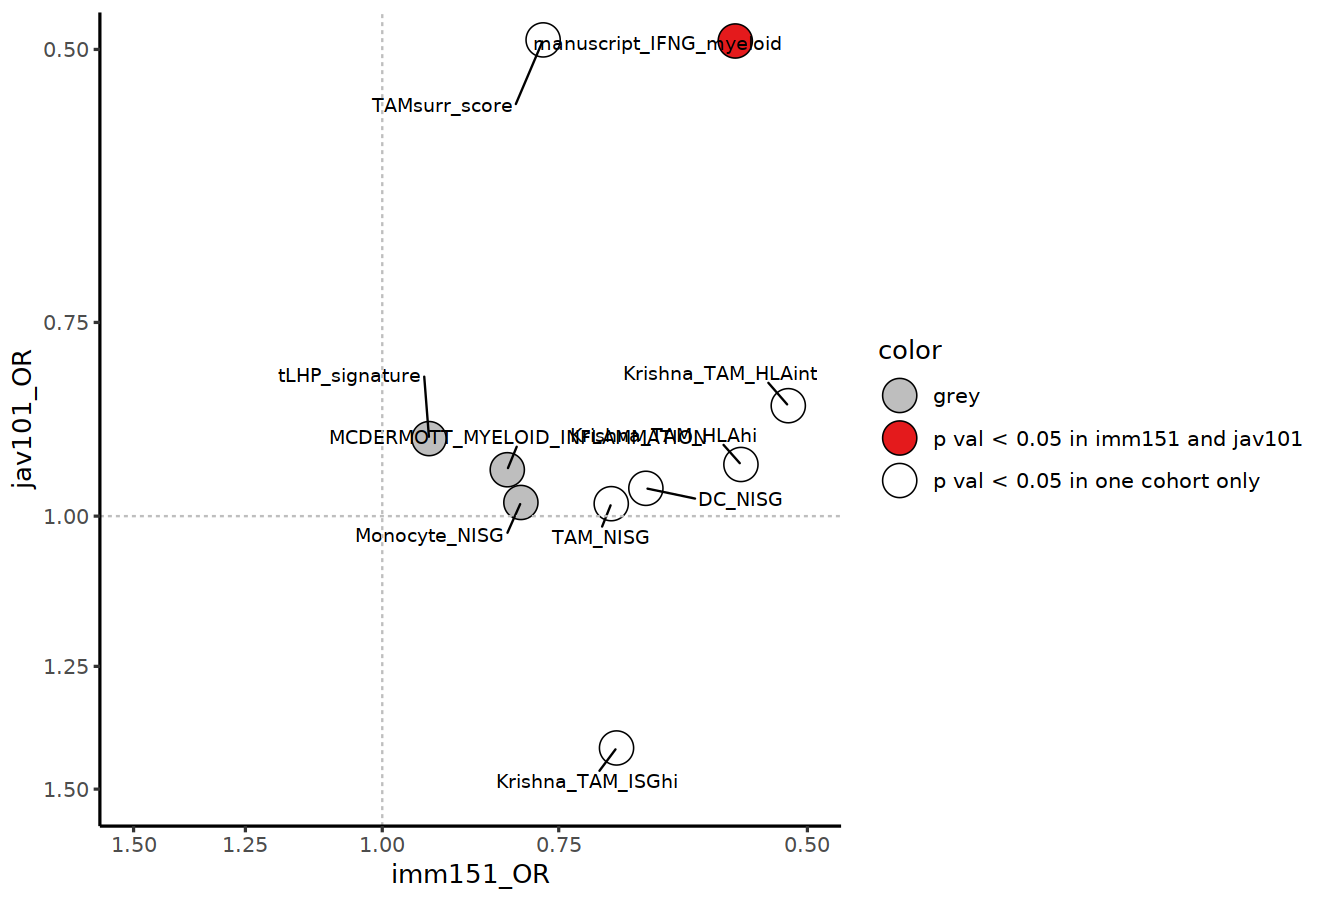

In [80]:
scatter_df = mutate(scatter_df, color = ifelse(imm151_pval < 0.05 & jav101_pval < 0.05, "p val < 0.05 in imm151 and jav101",ifelse(imm151_pval < 0.05 | jav101_pval < 0.05, "p val < 0.05 in one cohort only","grey")))
scatter_df$label = row.names(scatter_df)

library(ggrepel)
options(repr.plot.width=11, repr.plot.height=7.5)
ggplot(scatter_df, aes(x=imm151_OR, y=jav101_OR, fill = color, label = label)) +
  geom_point(size=9, shape = 21) + theme_classic(base_size = 15) + scale_fill_manual(values = c("grey","#e41a1c","white")) + geom_text_repel(box.padding = 1, max.overlaps = Inf) +
geom_vline(xintercept = 1, color = "grey",linetype = "dashed") + 
geom_hline(yintercept = 1, color = "grey",linetype = "dashed") +
coord_trans(x = c("log","reverse"), y = c("log","reverse"),xlim = c(0.5,1.5),ylim = c(0.5,1.5))

ggsave("../Figures/Figure4/Figure4E_scatter_myeloid_ORs.pdf", width = 11, height = 7.5)

In [2]:
print(sessionInfo())
print(version)

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /usr/lib64/libblas.so.3.4.2
LAPACK: /broad/software/free/Linux/redhat_7_x86_64/pkgs/r_4.1.0/lib64/R/lib/libRlapack.so

locale:
[1] C

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pROC_1.17.0.1          scales_1.3.0           forestmodel_0.6.2     
 [4] forcats_0.5.2          purrr_0.3.5            readr_2.0.0           
 [7] tidyr_1.2.1            tibble_3.1.8           tidyverse_1.3.1       
[10] survminer_0.4.9.999    survival_3.2-11        yarrr_0.1.5           
[13] circlize_0.4.15        BayesFactor_0.9.12-4.2 coda_0.19-4           
[16] jpeg_0.1-9             broom_1.0.1            magrittr_2.0.3        
[19] pheatmap_1.0.12        ggridges_0.5.4         hrbrthemes_0.8.0      
[22] viridis_0.6.1          viridisLite_0.4.2    